
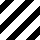
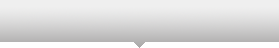
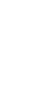
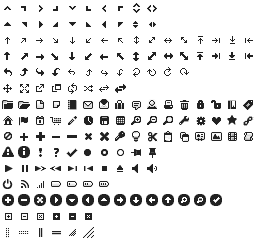
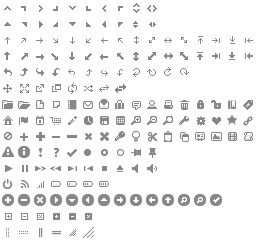
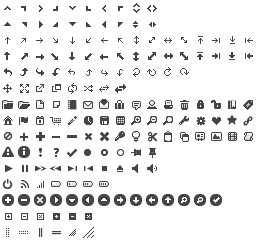
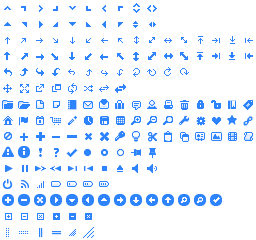
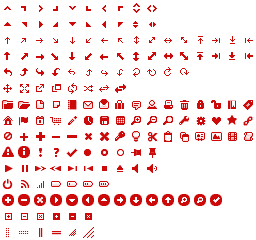
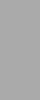
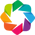
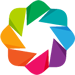
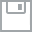
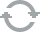
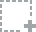
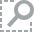
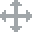
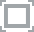
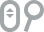

Using Theano backend.


In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from sklearn import cross_validation
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from ipywidgets import widgets
from IPython.display import display
from scipy.optimize import curve_fit
import copy
import time
import pickle
output_notebook()
%matplotlib inline

from keras.models import Sequential
from keras.layers.core import Dense, Activation,Dropout
from keras.optimizers import SGD
from keras.regularizers import l1, l2
from keras.models import model_from_json

In [2]:
def make_labels(values, criterion):
    return values.map(lambda x: int(x>criterion))

In [3]:
def add_roc(fpr,tpr,p, name, color):
    # add a line renderer with legend and line thickness
    p.line(fpr, tpr, legend=name, line_width=2, color=color)
    return 

In [4]:
def assess(y_true, preds, name='classifier'):
    if (len(preds[preds==0]))!=0 :
        specificity = len(preds[(preds==0)&(y_true==0)])/(len(y_true[y_true==0]))
    else:
        specificity = 0
    plt.figure(figsize = (10,7))
    cm = confusion_matrix(y_true,preds)
    sns.heatmap(cm, annot = True,fmt = 'd', annot_kws={"fontsize":20})
    plt.title('Confusion Matrix for {0}'.format(name), fontsize=30)
    plt.xlabel("Accuracy: {0:.2f} \nRecall: {1:.2f}\nSpecificity: {2:.2f}".format(accuracy_score(y_true,preds),
                                                                      recall_score(y_true, preds),
                                                                      specificity),fontsize= 20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    return cm

In [4]:
def unpickle(string):
    with open(string, 'r') as f:
        return pickle.load(f)

<h2 style="color:#3d566e">Importing data and Creating a balanced binary dataset </h2>

In [306]:
data = pd.read_csv('data_clean.csv',dtype=np.float32)
data.head()

MYC_body_UTA  CTCF_body_UTA  POLR2A_body_UTA  ARID3A_body_Stanford  \
0           0.0            0.0              0.0                   0.0   
1           0.0            0.0              0.0                   0.0   
2           0.0            0.0              0.0                   0.0   
3           0.0            0.0              0.0                   0.0   
4           0.0            0.0              0.0                   0.0   

   ATF1_body_HMS  ATF3_body_HMS  BACH1_body_Stanford  BDP1_body_HMS  \
0            0.0            0.0                  0.0            0.0   
1            0.0            0.0                  0.0            0.0   
2            0.0            0.0                  0.0            0.0   
3            0.0            0.0                  0.0            0.0   
4            0.0            0.0                  0.0            0.0   

   BHLHE40_body_Stanford  BRF2_body_HMS   ...     EIF4G2_body_UCSD.1  \
0                    0.0            0.0   ...                    0.0   
1                    0.0            0.0   ...                    0.0   
2                    0.0            0.0   ...                    0.0   
3                    0.0            0.0   ...                    0.0   
4                    0.0            0.0   ...                    0.0   

   AUH_body_UCSD.1  IGF2BP1_body_UCSD.1  HNRNPM_body_UCSD.1  SLTM_body_UCSD.1  \
0              0.0                  0.0                 0.0               0.0   
1              0.0                  0.0                 0.0               0.0   
2              0.0                  0.0                 0.0               0.0   
3              0.0                  0.0                 0.0               0.0   
4              0.0                  0.0                 0.0               0.0   

   IGF2BP2_body_UCSD  IGF2BP2_body_UCSD.1  LARP7_body_UCSD.1  \
0                0.0                  0.0                0.0   
1                0.0                  0.0                0.0   
2                0.0                  0.0                0.0   
3                0.0                  0.0                0.0   
4                0.0                  0.0                0.0   

   DDX42_body_UCSD.1      psi  
0                0.0  1.00000  
1                0.0  1.00000  
2                0.0  1.00000  
3                0.0  1.00000  
4                0.0  0.34868  

[5 rows x 300 columns]

In [307]:
cdata = data[(data['psi']>.7) | (data['psi']<.3)]
cX, cy = shuffle(cdata.ix[:,:-1], cdata.ix[:,-1])
X_train, X_test, y_train, y_test = cross_validation.train_test_split(cX,
                                                                     cy,
                                                                     test_size = .2)
X_train, X_valid, y_train, y_valid = cross_validation.train_test_split(X_train,
                                                                        y_train,
                                                                        test_size = .25)

In [308]:
X_train.reset_index(drop= True, inplace=True)
y_train.reset_index(drop= True, inplace=True)

X_valid.reset_index(drop= True, inplace=True)
X_valid=np.array(X_valid)
y_valid.reset_index(drop= True, inplace=True)

X_test.reset_index(drop= True, inplace=True)
X_test = np.array(X_test)
y_test.reset_index(drop= True, inplace=True)



y_train_labels = make_labels(y_train, .7)
y_valid_labels = make_labels(y_valid, .7)
y_test_labels = make_labels(y_test, .7)

In [309]:
print "Class population:\n label 0: {0:.2f}\n label 1: {1:.2f}".format(sum(y_train_labels==0)/len(y_train_labels),
                                                               sum(y_train_labels==1)/len(y_train_labels))

Class population:
 label 0: 0.12
 label 1: 0.88


In [310]:
indices = []
indices_0 = np.where(y_train_labels==0)[0].tolist()
indices_1 = np.where(y_train_labels==1)[0].tolist()

indices.extend(indices_0)
indices.extend(indices_1[:len(indices_0)])

balanced_X = np.array(X_train.ix[indices,:])
balanced_y = np.array(y_train_labels[indices])

len(balanced_X)

1980

In [11]:
random_indices = np.random.choice(range(len(balanced_y)),replace=False, size=len(balanced_y))

In [12]:
balanced_X = balanced_X[random_indices,:]
balanced_y = balanced_y[random_indices]

In [5]:
balanced_X = unpickle('balanced_X')
balanced_y = unpickle('balanced_y')
X_valid = unpickle('X_valid')
y_valid = unpickle('y_valid')
y_valid_labels = unpickle('y_valid_labels')

In [6]:
print "Class population:\n label 0: {0:.2f}\n label 1: {1:.2f}".format(sum(balanced_y==0)/len(balanced_y),
                                                               sum(balanced_y==1)/len(balanced_y))

Class population:
 label 0: 0.50
 label 1: 0.50


<h3 style="color:#e74c3c">One hot encoding</h3>

In [8]:
enc = OneHotEncoder()
enc.fit(np.array([0,1]).reshape(-1,1))

OneHotEncoder(categorical_features='all', dtype=<type 'float'>,
       handle_unknown='error', n_values='auto', sparse=True)

In [9]:
balanced_y_hot = enc.transform(balanced_y.reshape(-1,1)).toarray()

In [10]:
balanced_y

array([0, 0, 1, ..., 1, 0, 1])

In [11]:
print balanced_y[0:5]
print '===> \n'
print balanced_y_hot[0:5]

[0 0 1 1 1]
===> 

[[ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]]


<h3 style="color:#27ae60">Random Forest</h3>

In [7]:
rf = RandomForestClassifier(n_estimators=50,oob_score=True)
rf.fit(balanced_X, balanced_y)
#preds = rf.predict(X_valid)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [8]:
preds_rf_training = rf.predict(X_valid)

In [13]:
probs_rf = rf.predict_proba(X_valid)

In [9]:
accuracy_score(y_valid_labels,preds_rf_training)

0.83972503617945005

array([[ 291,   39],
       [ 391, 2043]])

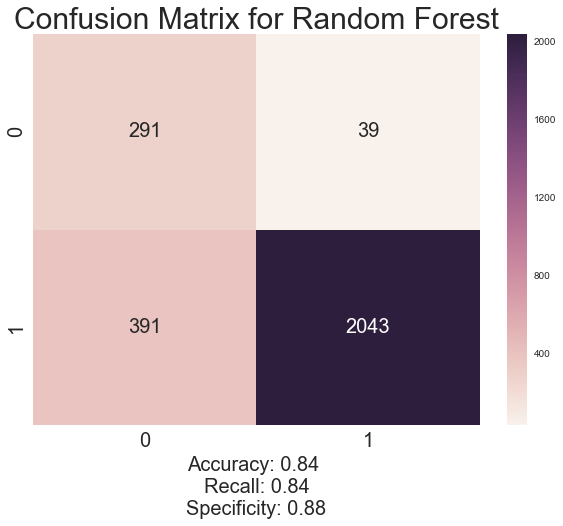

In [142]:
assess(y_valid_labels.values,preds,'Random Forest')

<h2 style="color:lightskyblue"> OOB Error </h2>

In [187]:
oob_preds = rf.oob_decision_function_
oob_labels = np.argmax(oob_preds,axis=1)
print "OOB Accuracy: {0:.2f}".format(accuracy_score(balanced_y, oob_labels))
print "Training Accuracy: {0:.2f}".format(accuracy_score(balanced_y, rf.predict(balanced_X)))

OOB Accuracy: 0.86
Training Accuracy: 1.00


In [188]:
confused_oob = np.where(balanced_y!=oob_labels)

<h2 style="color:#3d566e">Feature importace per Random Forest</h2>

In [143]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(balanced_X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 277 (0.066728)
2. feature 296 (0.063633)
3. feature 283 (0.063221)
4. feature 292 (0.058775)
5. feature 295 (0.056430)
6. feature 249 (0.052533)
7. feature 284 (0.039778)
8. feature 255 (0.034163)
9. feature 265 (0.032940)
10. feature 274 (0.032084)
11. feature 253 (0.030469)
12. feature 261 (0.030104)
13. feature 266 (0.030063)
14. feature 257 (0.029770)
15. feature 260 (0.028752)
16. feature 287 (0.022921)
17. feature 272 (0.019947)
18. feature 268 (0.019650)
19. feature 65 (0.017497)
20. feature 256 (0.017425)
21. feature 288 (0.016682)
22. feature 2 (0.016599)
23. feature 269 (0.015838)
24. feature 267 (0.013635)
25. feature 270 (0.012389)
26. feature 250 (0.011383)
27. feature 290 (0.010646)
28. feature 254 (0.010018)
29. feature 247 (0.009582)
30. feature 278 (0.008240)
31. feature 252 (0.007901)
32. feature 298 (0.007035)
33. feature 248 (0.005991)
34. feature 281 (0.005455)
35. feature 294 (0.005227)
36. feature 66 (0.005071)
37. feature 271 (0.00498

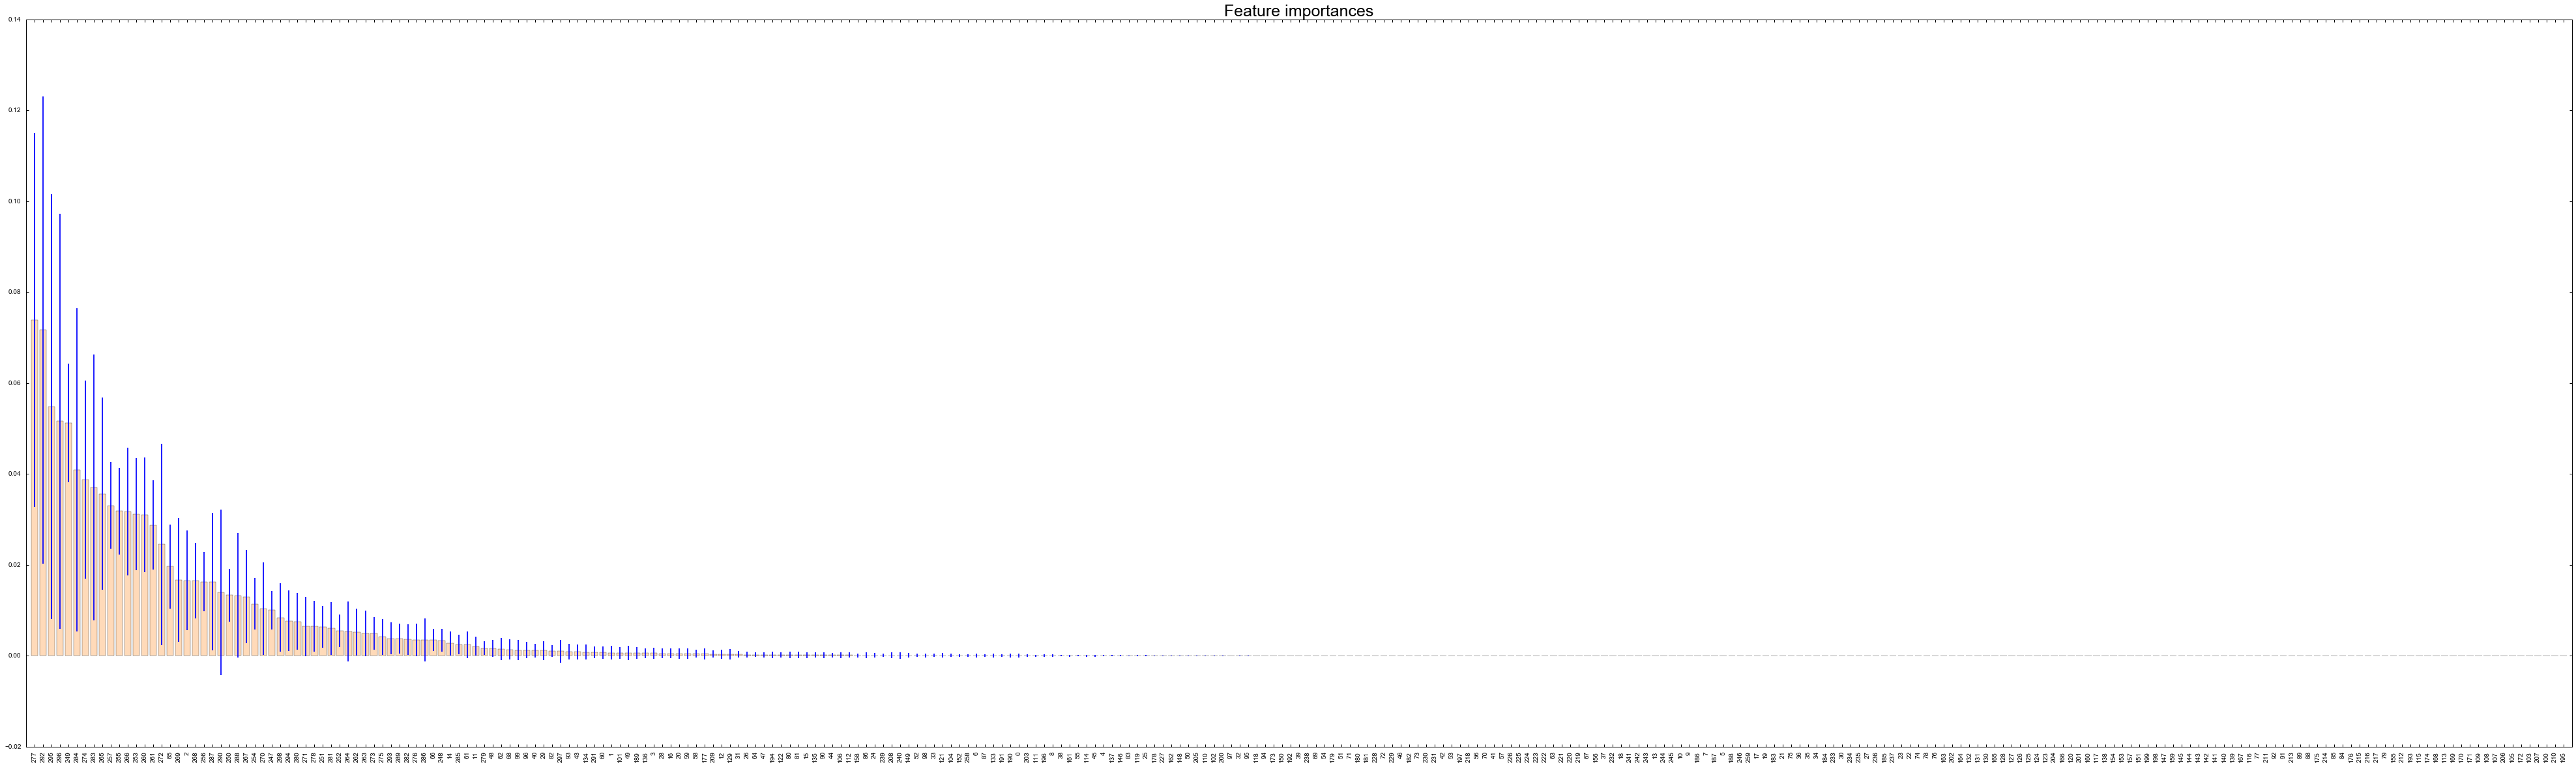

In [318]:
# Plot the feature importances of the forest
plt.figure(figsize=(70,20))
plt.style.use('seaborn-notebook')
plt.title("Feature importances", fontsize=25)
plt.bar(range(balanced_X.shape[1]), importances[indices],
       color="peachpuff", yerr=std[indices], align="center")
plt.xticks(range(balanced_X.shape[1]), indices,rotation=90)
plt.xlim([-1, balanced_X.shape[1]])
plt.show()

In [144]:
#The first 89 important features (up to feature 194) will be chosen
chosen_ones_X_train = balanced_X[:,indices[0:89]]

chosen_ones_X_valid = X_valid[:,indices[0:89]]

<h2 style="color:lightskyblue"> Random Forest on Important Features </h2>

In [145]:
rf_chosen = RandomForestClassifier(n_estimators=50)
rf_chosen.fit(chosen_ones_X_train,balanced_y)
preds_rf_chosen = rf_chosen.predict(chosen_ones_X_valid)

In [146]:
accuracy_score(y_valid_labels,preds_rf_chosen)

0.85202604920405212

array([[ 288,   42],
       [ 367, 2067]])

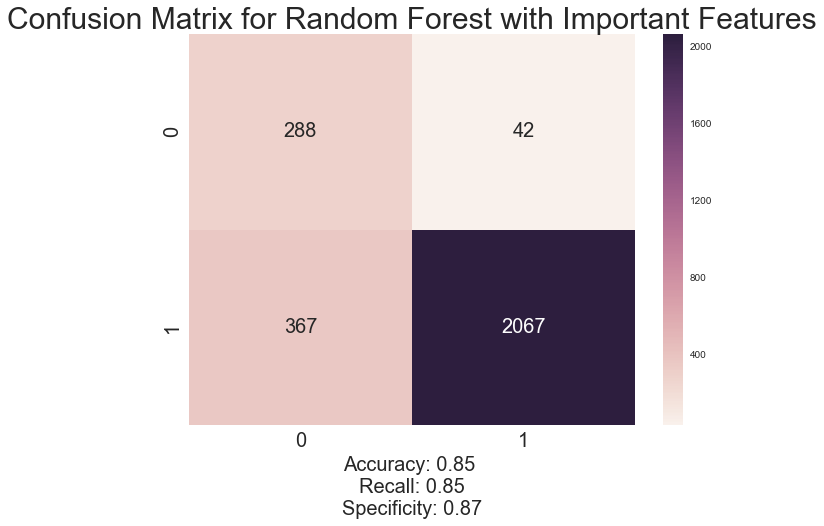

In [150]:
assess(y_valid_labels.values,preds_rf_chosen,'Random Forest with Important Features')

In [427]:
with open('chosen_ones_X_train', 'w') as f:
    pickle.dump(chosen_ones_X_train, f)
    
with open('chosen_ones_X_valid', 'w') as f:
    pickle.dump(chosen_ones_X_valid, f)

In [428]:
with open('chosen_ones_indices', 'w') as f:
    pickle.dump(indices[0:89], f)

<h3 style="color:#c0392b">Keras Deep Network</h3>

In [87]:
model = Sequential()

In [88]:
model.add(Dense(input_dim=np.shape(balanced_X)[1],output_dim=2,W_regularizer=l2(0.01)))
#model.add(Dropout(0.5))
model.add(Activation('softmax'))

In [89]:
model.compile(optimizer=SGD(lr=0.01,momentum=0.8,decay=1e-6,nesterov=True),
              loss='categorical_crossentropy',
              metrics=['accuracy'],)

In [90]:
model.fit(balanced_X,balanced_y_hot,nb_epoch=100, verbose = 0)

In [91]:
preds_m = model.predict_classes(X_valid, verbose = 0)

array([[ 280,   55],
       [ 775, 1654]])

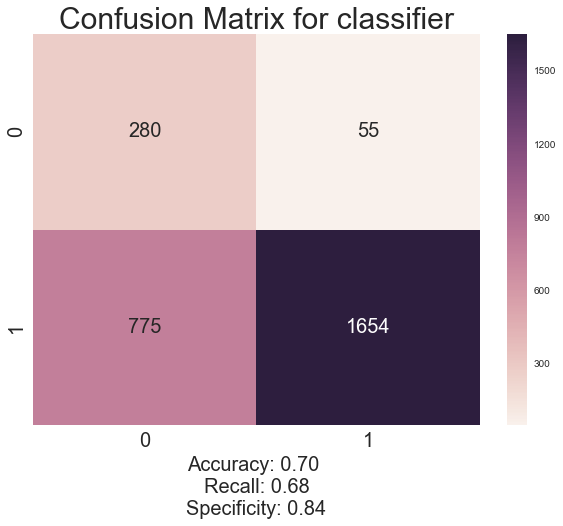

In [95]:
assess(y_valid_labels.values,preds_m)

<h3 style="color:#3d566e">Tunning for Neurons</h3>

In [84]:
def tuner(X_train,
          y_train,
          X_valid,
          y_valid,
          range_of_neurons,
          number_of_layers,
          previous_layers=[],
          learning_rate = 0.01,
          activation='tanh',
          l2_lambda=0.0,
          dropout=0.0,
          number_of_epochs=100):
    #TODO: Since the previous layers can be updated, put it in a loop to tune the layers too
    """This function will run one layer with many neurons and return its confusion matrix
       **DONT FORGET TO INPUT y_valid_labels.values***
       The idea is that from the output of this function the best number of neurons for this
       layer will be chosen, then that number will be appended to the list of previous layer,
       I am not doing it in the function because we might see merit in looking at the plot of
       the result of this function. This function must run many times for each """
    overall_results={}
    progress_layer = widgets.FloatProgress(min=0, max=100,color='#2981bb')
    progress_neuron = widgets.FloatProgress(min=0, max=100,color='#f39c12')
    display(progress_layer)
    display(progress_neuron)
    for layer in range(number_of_layers):
        t_layer = time.time()
        progress_layer.description="Layer %s"%layer                                        
        progress_layer.value = (layer+1)/number_of_layers*100
           
        overall_results[layer]=[]
        results = []
        #Now to tune the new layer        
        for n,neuron in enumerate(range_of_neurons): 
            t_neuron = time.time()
            progress_neuron.description="Neurons %s"%neuron                                             
            progress_neuron.value = (n+1)/len(range_of_neurons)*100
            
            #first construct the first layer
            model = Sequential()
            model.add(Dense(input_dim=np.shape(X_train)[1],
                                    output_dim=300, #299 + 1
                                    W_regularizer=l2(l2_lambda)))
            model.add(Activation(activation))
            model.add(Dropout(dropout))

            #Then construct the known network
            for entry in previous_layers: #entries are basically the number of tuned neurons
                model.add(Dense(output_dim=entry,
                                W_regularizer=l2(l2_lambda)))
                model.add(Activation(activation))
                model.add(Dropout(dropout))

            #Then add the new layer with the trial neurons
            model.add(Dense(output_dim=neuron,
                        W_regularizer=l2(l2_lambda)))
            model.add(Activation(activation))
            model.add(Dropout(dropout))

            #Softmax and compile
            model.add(Dense(output_dim=np.shape(y_train)[1],
                            W_regularizer=l2_lambda)) 
            model.add(Activation('softmax'))
            model.compile(optimizer=SGD(lr=learning_rate,
                                        momentum=0.8,
                                        decay=1e-6,
                                        nesterov=True),
                                        loss='categorical_crossentropy')

            model.fit(balanced_X,balanced_y_hot,nb_epoch=number_of_epochs, verbose = 0)
            preds = model.predict_classes(X_valid, verbose = 0)

            results.append((accuracy_score(y_valid, preds),neuron))
            overall_results[layer].append((confusion_matrix(y_valid, preds),neuron))
            
            print "Neuron %s done in %.2f seconds"%(neuron,time.time()-t_neuron)
        results_accuracy = [result[0] for result in results]

        #Getting the number of neurons with the most accuracy
        previous_layers.append(results[np.argmax(results_accuracy)][1])
        print "Layer %s done in %.2f seconds"%(layer,time.time()-t_layer)
        print '======\n'
        with open('overall_results_layer_%s'%layer,'w') as f:
            pickle.dump(overall_results, f)
        with open('layer_formation_%s'%layer,'w') as f:
            pickle.dump(previous_layers, f)
            
    return overall_results,previous_layers

In [83]:
overall_results = tuner(balanced_X,balanced_y_hot,X_valid,y_valid_labels.values,range(10,100,10),
                        2)

Neuron 10 done in 14.03 seconds
Neuron 20 done in 15.00 seconds
Neuron 30 done in 16.49 seconds
Neuron 40 done in 17.63 seconds
Neuron 50 done in 17.99 seconds
Neuron 60 done in 18.47 seconds
Neuron 70 done in 19.86 seconds
Neuron 80 done in 21.18 seconds
Neuron 90 done in 20.11 seconds
[(0.7503617945007236, 10), (0.77387843704775683, 20), (0.76772793053545585, 30), (0.77604920405209843, 40), (0.7858176555716353, 50), (0.76519536903039076, 60), (0.7872648335745297, 70), (0.7879884225759769, 80), (0.79196816208393628, 90)]


[0.7503617945007236, 0.77387843704775683, 0.76772793053545585, 0.77604920405209843, 0.7858176555716353, 0.76519536903039076, 0.7872648335745297, 0.7879884225759769, 0.79196816208393628]


[90]


Layer 0 done in 160.77 seconds

Neuron 10 done in 20.43 seconds
Neuron 20 done in 21.67 seconds
Neuron 30 done in 21.17 seconds
Neuron 40 done in 20.83 seconds
Neuron 50 done in 21.80 seconds
Neuron 60 done in 21.48 seconds
Neuron 70 done in 21.80 seconds
Neuron 80 done in 2

In [308]:
def accuracy_from_cm(confusion_matrix):
    denom = np.sum(confusion_matrix)
    num = confusion_matrix[0][0] + confusion_matrix[1][1]
    return num/denom

def specificity_from_cm(confusion_matrix):
    denom = np.sum(confusion_matrix[0])
    num = confusion_matrix[0][0]
    return num/denom
    

In [77]:
accuracy_neurons = {item:copy.deepcopy([(accuracy_from_cm(overall_results[item][j][0]),
                   overall_results[item][j][1])for j in range(9)]) for item in overall_results}

In [255]:
i=9
with open('overall_results_layer_%s'%i,'r') as f:
    overall = pickle.load(f)
with open('layer_formation_%s'%i,'r') as f:
    formation = pickle.load(f)
        

In [347]:
accuracy_neurons = {item:copy.deepcopy([(accuracy_from_cm(overall[item][j][0]),
                   overall[item][j][1])for j in range(len(range(10,500,20)))]) for item in overall}

In [348]:
acc_means = [np.mean([y[0] for y in accuracy_neurons[i]]) for i in range(10)]
acc_max = [np.max([y[0] for y in accuracy_neurons[i]]) for i in range(10)]

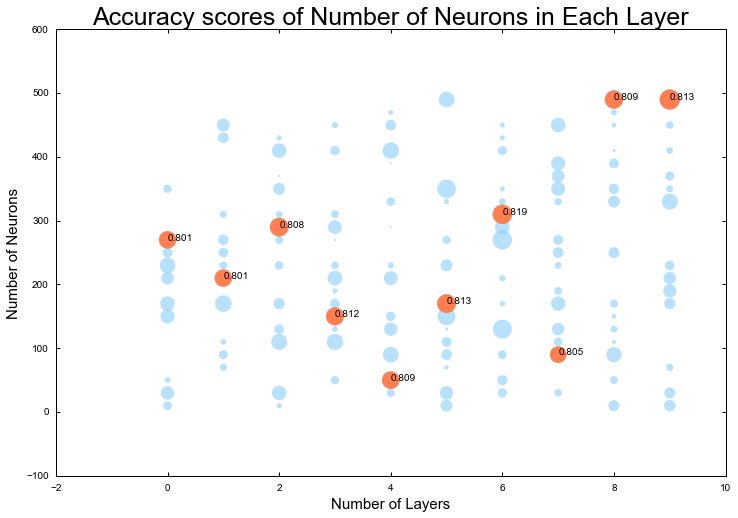

In [349]:
colors = ['lightskyblue','coral','greenyellow','darkcyan','crimson','forestgreen','black',
          'peachpuff']

plt.style.use('seaborn-notebook')
plt.figure(figsize=(12,8))
for i in range(10):
    plt.scatter([i]*len(range(10,500,20)),[x[1] for x in accuracy_neurons[i]],
                s= [(y[0]-acc_means[i])*1e4 for y in accuracy_neurons[i]],
                label='Layer %s'%i, alpha=.6, color=colors[0])
    
plt.scatter(range(10),formation,
                s= (np.array(acc_max)-np.array(acc_means))*1e4,
                label='Layer %s'%i, alpha=1, color=colors[1],)
for i in range(10):
    plt.annotate(xy=(i,formation[i]),s=format(float(acc_max[i]),'.3f'))
plt.title('Accuracy scores of Number of Neurons in Each Layer', fontsize=25)
plt.xlabel('Number of Layers',fontsize=15)
plt.ylabel('Number of Neurons', fontsize=15)

In [342]:
specificity_neurons = {item:copy.deepcopy([(specificity_from_cm(overall[item][j][0]),
                   overall[item][j][1])for j in range(len(range(10,500,20)))]) for item in overall}

spe_means = [np.mean([y[0] for y in specificity_neurons[i]]) for i in range(10)]
spe_max = [np.max([y[0] for y in specificity_neurons[i]]) for i in range(10)]

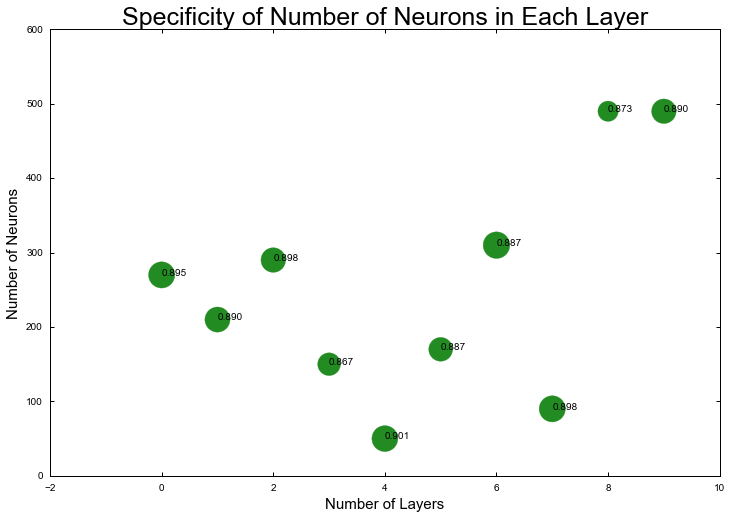

In [351]:
colors = ['lightskyblue','coral','greenyellow','darkcyan','crimson','forestgreen','black',
          'peachpuff']

plt.style.use('seaborn-notebook')
plt.figure(figsize=(12,8))
plt.scatter(range(10),formation,
                s= (np.array(spe_max)-np.array(spe_means))*1e4,
                label='Layer %s'%i, alpha=1, color=colors[5],)
for i in range(10):
    plt.annotate(xy=(i,formation[i]),s=format(float(spe_max[i]),'.3f'))
    
    
# plt.scatter(range(10),formation,
#                 s= (np.array(acc_max)-np.array(acc_means))*1e4,
#                 label='Layer %s'%i, alpha=1, color=colors[1],)
# for i in range(10):
#     plt.annotate(xy=(i,formation[i]),s=format(float(acc_max[i]),'.3f'))
plt.title('Specificity of Number of Neurons in Each Layer', fontsize=25)
plt.xlabel('Number of Layers',fontsize=15)
plt.ylabel('Number of Neurons', fontsize=15)

In [210]:
with open('l2_results','r') as f:
    overall_l2 = pickle.load(f)

In [368]:
accuracy_l2 = {item:copy.deepcopy([(accuracy_from_cm(overall_l2[item][0][0]),
                   overall_l2[item][0][1])]) for item in overall_l2}

acc_l2 = np.array([[y[0] for y in accuracy_l2[i]] for i in accuracy_l2])

specificity_l2 = {item:copy.deepcopy([(specificity_from_cm(overall_l2[item][0][0]),
                   overall_l2[item][0][1])]) for item in overall_l2}

spe_l2 = np.array([[y[0] for y in specificity_l2[i]] for i in specificity_l2])

In [378]:
sorted_indices_for_l2= np.argsort(np.log(accuracy_l2.keys()))

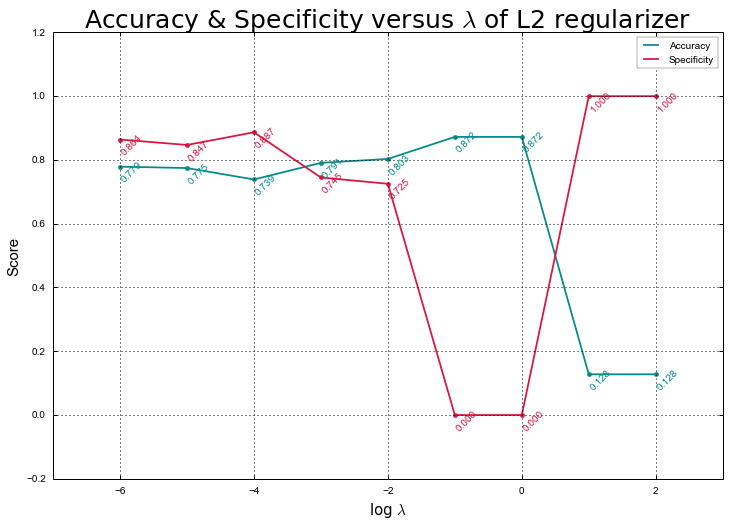

In [426]:
plt.style.use('seaborn-notebook')
plt.figure(figsize=(12,8))
plt.scatter(np.log10(accuracy_l2.keys()),acc_l2, alpha=1, color=colors[3])
plt.plot(np.log10(accuracy_l2.keys())[sorted_indices_for_l2],
         acc_l2[sorted_indices_for_l2], alpha=1, color=colors[3],label='Accuracy')
plt.scatter(np.log10(specificity_l2.keys()),spe_l2, alpha=1, color=colors[4])
plt.plot(np.log10(specificity_l2.keys())[sorted_indices_for_l2],
         spe_l2[sorted_indices_for_l2], alpha=1, color=colors[4],label='Specificity')
for i in range(9):
     plt.annotate(xy=(np.log10(accuracy_l2.keys())[sorted_indices_for_l2][i],
         acc_l2[sorted_indices_for_l2][i]),
                  s=format(float(acc_l2[sorted_indices_for_l2][i]),'.3f'),color=colors[3],
                 rotation=45)
    
for i in range(9):
     plt.annotate(xy=(np.log10(specificity_l2.keys())[sorted_indices_for_l2][i],
         spe_l2[sorted_indices_for_l2][i]),
                  s=format(float(spe_l2[sorted_indices_for_l2][i]),'.3f'),color=colors[4],
                 rotation=45)
        
plt.title('Accuracy & Specificity versus $\lambda$ of L2 regularizer', fontsize=25)
plt.xlabel('log $\lambda$',fontsize=15)
plt.ylabel('Score', fontsize=15)
plt.legend()
plt.grid()

<h2 style="color:lightskyblue"> Random Forest on Important Features </h2>

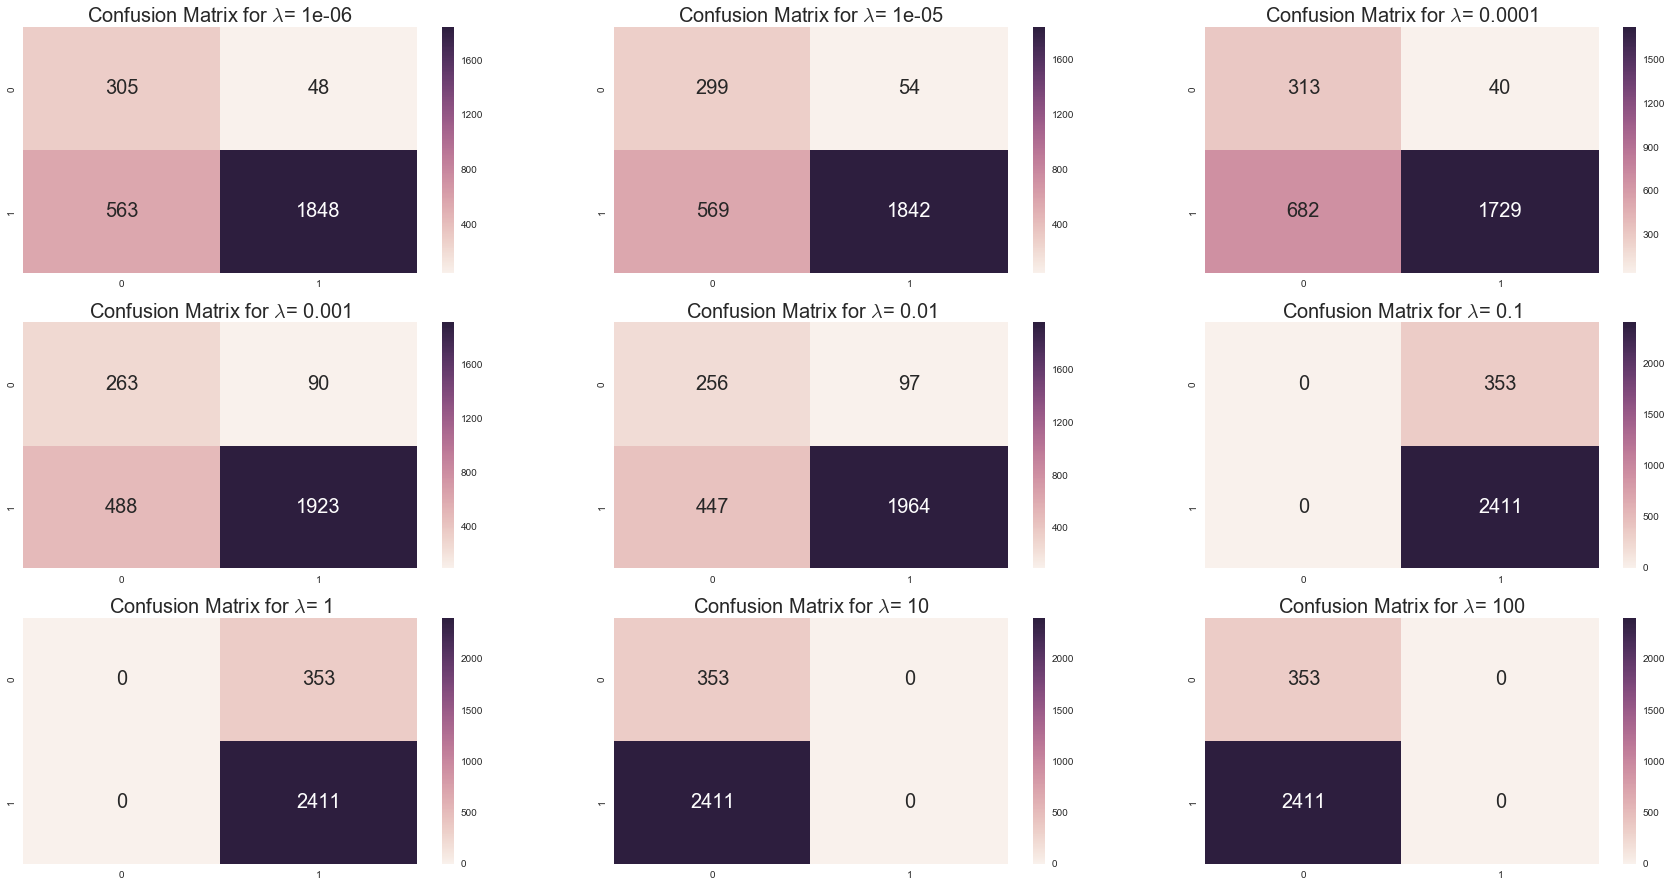

In [308]:
keys_l2 = np.sort(overall_l2.keys())
plt.figure(figsize=(30,15))
for i in range(9):
    plt.subplot(3,3,i+1)
    sns.heatmap(overall_l2[keys_l2[i]][0][0], annot = True,fmt = 'd', annot_kws={"fontsize":20})
    plt.title('Confusion Matrix for $\lambda$= {0}'.format(overall_l2[keys_l2[i]][0][1]), fontsize=20)

In [227]:
with open('dropout_results','r') as f:
    overall_dropout = pickle.load(f)

In [399]:
accuracy_dropout = {item:copy.deepcopy([(accuracy_from_cm(overall_dropout[item][0][0]),
                   overall_dropout[item][0][1])]) for item in overall_dropout}

acc_d = np.array([[y[0] for y in accuracy_dropout[i]] for i in accuracy_dropout])

specificity_dropout = {item:copy.deepcopy([(specificity_from_cm(overall_dropout[item][0][0]),
                   overall_dropout[item][0][1])]) for item in overall_dropout}

spe_d = np.array([[y[0] for y in specificity_dropout[i]] for i in specificity_dropout])

In [410]:
sorted_key_indices = np.argsort(accuracy_dropout.keys())

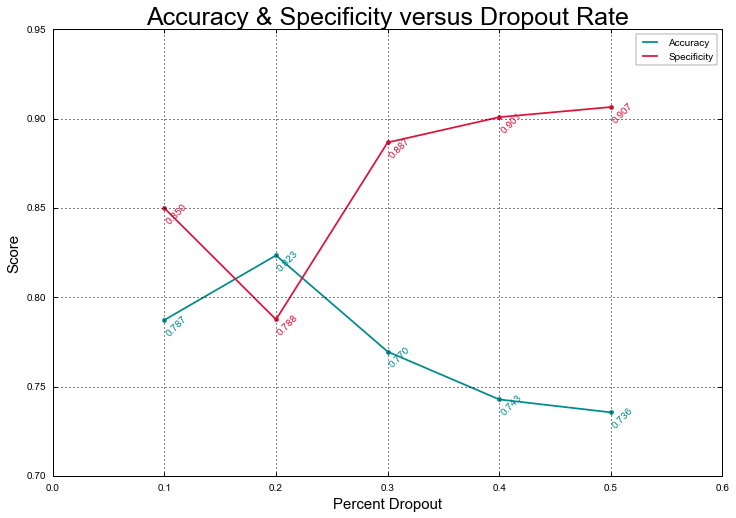

In [425]:
plt.style.use('seaborn-notebook')
plt.figure(figsize=(12,8))
plt.scatter(np.array(accuracy_dropout.keys())[sorted_key_indices],
            acc_d[sorted_key_indices], alpha=1, color=colors[3])
plt.plot(np.array(accuracy_dropout.keys())[sorted_key_indices],
         acc_d[sorted_key_indices], alpha=1, color=colors[3],label='Accuracy')

plt.scatter(np.array(specificity_dropout.keys())[sorted_key_indices],
            spe_d[sorted_key_indices], alpha=1, color=colors[4])
plt.plot(np.array(specificity_dropout.keys())[sorted_key_indices],
         spe_d[sorted_key_indices], alpha=1, color=colors[4],label='Specificity')
for i in range(5):
     plt.annotate(xy=(np.array(accuracy_dropout.keys())[sorted_key_indices][i],
         acc_d[sorted_key_indices][i]),s=format(float(acc_d[sorted_key_indices][i]),'.3f'),
                  color=colors[3],
                 rotation=45)
    
for i in range(5):
     plt.annotate(xy=(np.array(specificity_dropout.keys())[sorted_key_indices][i],
         spe_d[sorted_key_indices][i]),s=format(float(spe_d[sorted_key_indices][i]),'.3f'),
                  color=colors[4],
                 rotation=45)
        
plt.title('Accuracy & Specificity versus Dropout Rate', fontsize=25)
plt.xlabel('Percent Dropout',fontsize=15)
plt.ylabel('Score', fontsize=15)
plt.legend()
plt.grid()

## MLP 1 Layer

In [302]:
with open('overall_results_layer_MLP','r') as f:
    overall_mlp = pickle.load(f)
with open('layer_formation_0 _MLP','r') as f:
    formation_mlp = pickle.load(f)
        

In [303]:
with open('overall_results_mlp_2','r') as f:
    overall_mlp_2 = pickle.load(f)
        

In [304]:
with open('overall_results_mlp_more_points','r') as f:
    overall_mlp_3 = pickle.load(f)

In [305]:
overall_mlp[0].extend(overall_mlp_2[0])

In [306]:
overall_mlp[0].extend(overall_mlp_3[0])

In [309]:
accuracy_neurons_mlp = {item:copy.deepcopy([(accuracy_from_cm(overall_mlp[item][j][0]),
                   overall_mlp[item][j][1])for j in range(9)]) for item in overall_mlp}

accuracy_neurons_mlp_2 = {item:copy.deepcopy([(accuracy_from_cm(overall_mlp[item][j][0]),
                   overall_mlp[item][j][1])for j in range(21)[9:]]) for item in overall_mlp}

In [310]:
sorted_indices = np.argsort([x[1] for x in accuracy_neurons_mlp[0]])
x_to_plot = np.array([x[1] for x in accuracy_neurons_mlp[0]])[sorted_indices]
y_to_plot = np.array([x[0] for x in accuracy_neurons_mlp[0]])[sorted_indices]

In [311]:
sorted_indices_2 = np.argsort([x[1] for x in accuracy_neurons_mlp_2[0]])
x_to_plot_2 = np.array([x[1] for x in accuracy_neurons_mlp_2[0]])[sorted_indices_2]
y_to_plot_2 = np.array([x[0] for x in accuracy_neurons_mlp_2[0]])[sorted_indices_2]

In [324]:
x_prime = np.concatenate((x_to_plot.reshape(1,-1),x_to_plot_2.reshape(1,-1)),axis=1)[0]
y_prime = np.concatenate((y_to_plot.reshape(1,-1),y_to_plot_2.reshape(1,-1)),axis=1)[0]

In [326]:
indices_prime = np.argsort(x_prime)
x_prime = x_prime[indices_prime]
y_prime = y_prime[indices_prime]

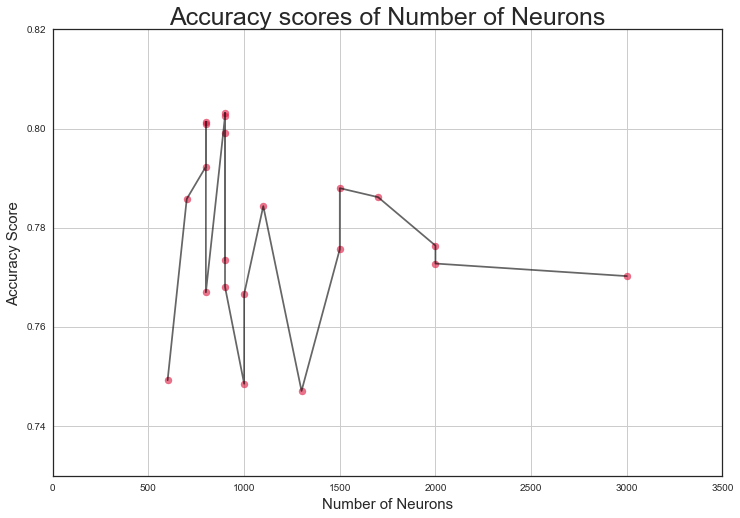

In [339]:
colors = ['lightskyblue','coral','greenyellow','darkcyan','crimson','forestgreen','black',
          'peachpuff']

plt.style.use('seaborn-white')
plt.figure(figsize=(12,8))

plt.scatter(x_prime,y_prime,alpha=.6, color='crimson', marker='o',s=50)
plt.plot(x_prime,y_prime,alpha=.6, color=colors[6])

plt.title('Accuracy scores of Number of Neurons', fontsize=25)
plt.xlabel('Number of Neurons',fontsize=15)
plt.ylabel('Accuracy Score', fontsize=15)
plt.grid()

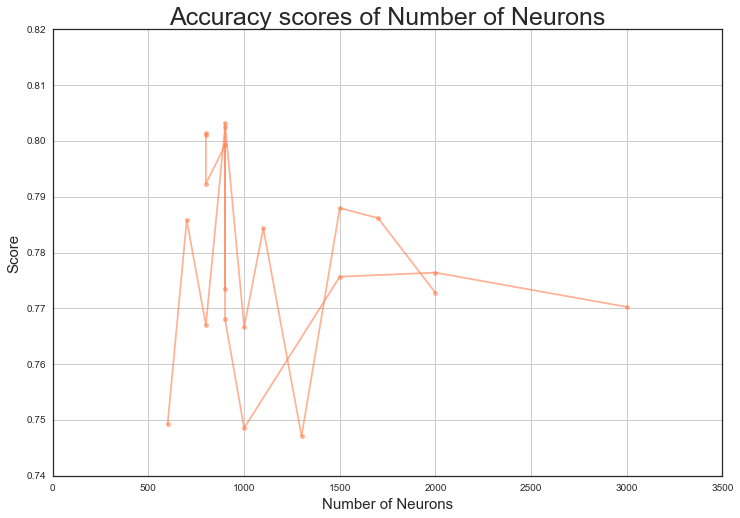

In [313]:
colors = ['lightskyblue','coral','greenyellow','darkcyan','crimson','forestgreen','black',
          'peachpuff']

plt.style.use('seaborn-white')
plt.figure(figsize=(12,8))

plt.scatter(x_to_plot,y_to_plot,alpha=.6, color=colors[1])
plt.plot(x_to_plot,y_to_plot,alpha=.6, color=colors[1])

plt.scatter(x_to_plot_2,y_to_plot_2,alpha=.6, color=colors[1])
plt.plot(x_to_plot_2,y_to_plot_2,alpha=.6, color=colors[1])

plt.title('Accuracy scores of Number of Neurons', fontsize=25)
plt.xlabel('Number of Neurons',fontsize=15)
plt.ylabel('Score', fontsize=15)
plt.grid()

## L1 and L2 on MLP, full features

In [591]:
with open('l2_results_mlp_800','r') as f:
    l2_results_mlp_800 = pickle.load(f)
with open('l2_results_mlp_900','r') as f:
    l2_results_mlp_900 = pickle.load(f)
with open('l1_results_mlp_800','r') as f:
    l1_results_mlp_800 = pickle.load(f)
with open('l1_results_mlp_900','r') as f:
    l1_results_mlp_900 = pickle.load(f)

In [628]:
class regularizer_shower:
    def __init__(self, filename):
        with open(filename,'r') as f:
            overall = pickle.load(f)
        self.accuracy = {item:copy.deepcopy([(accuracy_from_cm(overall[item][0][0]),
                   overall[item][0][1])]) for item in overall}
        self.acc = np.array([[y[0] for y in self.accuracy[i]] for i in self.accuracy])
        self.specificity = {item:copy.deepcopy([(specificity_from_cm(overall[item][0][0]),
                   overall[item][0][1])]) for item in overall}
        self.spe = np.array([[y[0] for y in self.specificity[i]] for i in self.specificity])
        self.sorted_indices = np.argsort(np.log(self.accuracy.keys()))
        
    def plot(self,color_acc,color_spe,label_acc, label_spe):
        plt.scatter(np.log10(self.accuracy.keys()),self.acc, alpha=1, color=color_acc)
        plt.plot(np.log10(self.accuracy.keys())[self.sorted_indices],
                 self.acc[self.sorted_indices],
                 alpha=1,
                 color=color_acc,
                 label=label_acc)

        plt.scatter(np.log10(self.specificity.keys()),self.spe, alpha=1, color=color_spe)
        plt.plot(np.log10(self.specificity.keys())[self.sorted_indices],
                 self.spe[self.sorted_indices],
                 alpha=1,
                 color=color_spe,
                 label=label_spe)

        for i in range(5):
             plt.annotate(xy=(np.log10(self.accuracy.keys())[self.sorted_indices][i],
                 self.acc[self.sorted_indices][i]),
                          s=format(float(self.acc[self.sorted_indices][i]),'.3f'),
                          color=color_acc,
                          rotation=45)

        for i in range(5):
             plt.annotate(xy=(np.log10(self.specificity.keys())[self.sorted_indices][i],
                          self.spe[self.sorted_indices][i]),
                          s=format(float(self.spe[self.sorted_indices][i]),'.3f'),color=color_spe,
                          rotation=45)
        

In [653]:
rs_l2800 = regularizer_shower('l2_results_mlp_800')
rs_l2900 = regularizer_shower('l2_results_mlp_900')
rs_l1800 = regularizer_shower('l1_results_mlp_800')
rs_l1900 = regularizer_shower('l1_results_mlp_900')

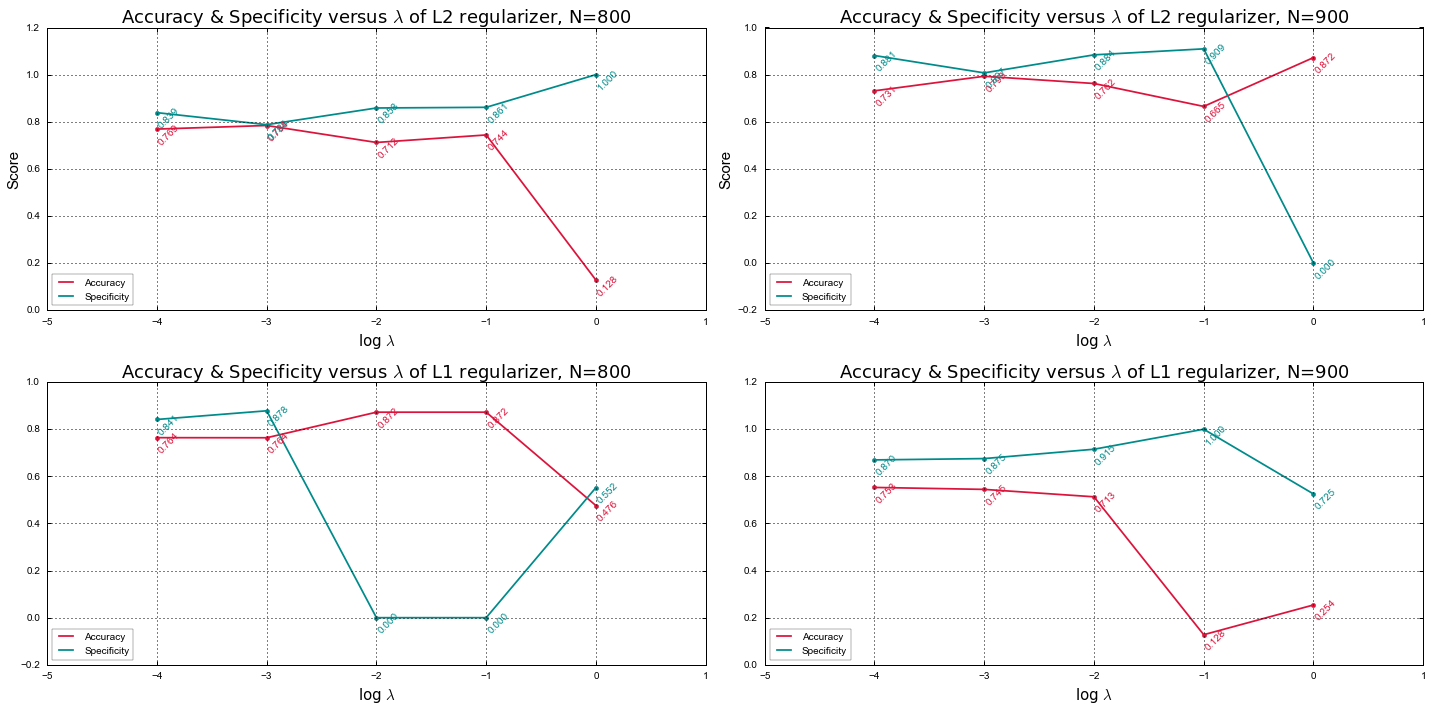

In [650]:
plt.style.use('seaborn-notebook')
plt.figure(figsize=(20,10))


plt.subplot(2,2,1)
rs_l2800.plot(color_acc='crimson',color_spe='darkcyan',label_acc='Accuracy',label_spe='Specificity')
plt.title('Accuracy & Specificity versus $\lambda$ of L2 regularizer, N=800', fontsize=18)
plt.xlabel('log $\lambda$',fontsize=15)
plt.ylabel('Score', fontsize=15)
plt.legend(loc='lower left')
plt.grid()

plt.subplot(2,2,2)
rs_l2900.plot(color_acc='crimson',color_spe='darkcyan',label_acc='Accuracy',label_spe='Specificity')

plt.title('Accuracy & Specificity versus $\lambda$ of L2 regularizer, N=900', fontsize=18)
plt.xlabel('log $\lambda$',fontsize=15)
plt.ylabel('Score', fontsize=15)
plt.legend(loc='lower left')
plt.grid()


plt.subplot(2,2,3)
rs_l1800.plot(color_acc='crimson',color_spe='darkcyan',label_acc='Accuracy',label_spe='Specificity')
plt.title('Accuracy & Specificity versus $\lambda$ of L1 regularizer, N=800', fontsize=18)        
plt.xlabel('log $\lambda$',fontsize=15)
plt.legend(loc='lower left')
plt.grid()

plt.subplot(2,2,4)
rs_l1900.plot(color_acc='crimson',color_spe='darkcyan',label_acc='Accuracy',label_spe='Specificity')

plt.title('Accuracy & Specificity versus $\lambda$ of L1 regularizer, N=900', fontsize=18)        
plt.xlabel('log $\lambda$',fontsize=15)
plt.legend(loc='lower left')
plt.grid()

plt.tight_layout()

## L1 and L2 on MLP, Chosen Features

In [652]:
rs_l2800_chosen = regularizer_shower('l2_results_mlp_chosen_800')
rs_l2900_chosen = regularizer_shower('l2_results_mlp_chosen_900')
rs_l1800_chosen = regularizer_shower('l1_results_mlp_chosen_800')
rs_l1900_chosen = regularizer_shower('l1_results_mlp_chosen_900')

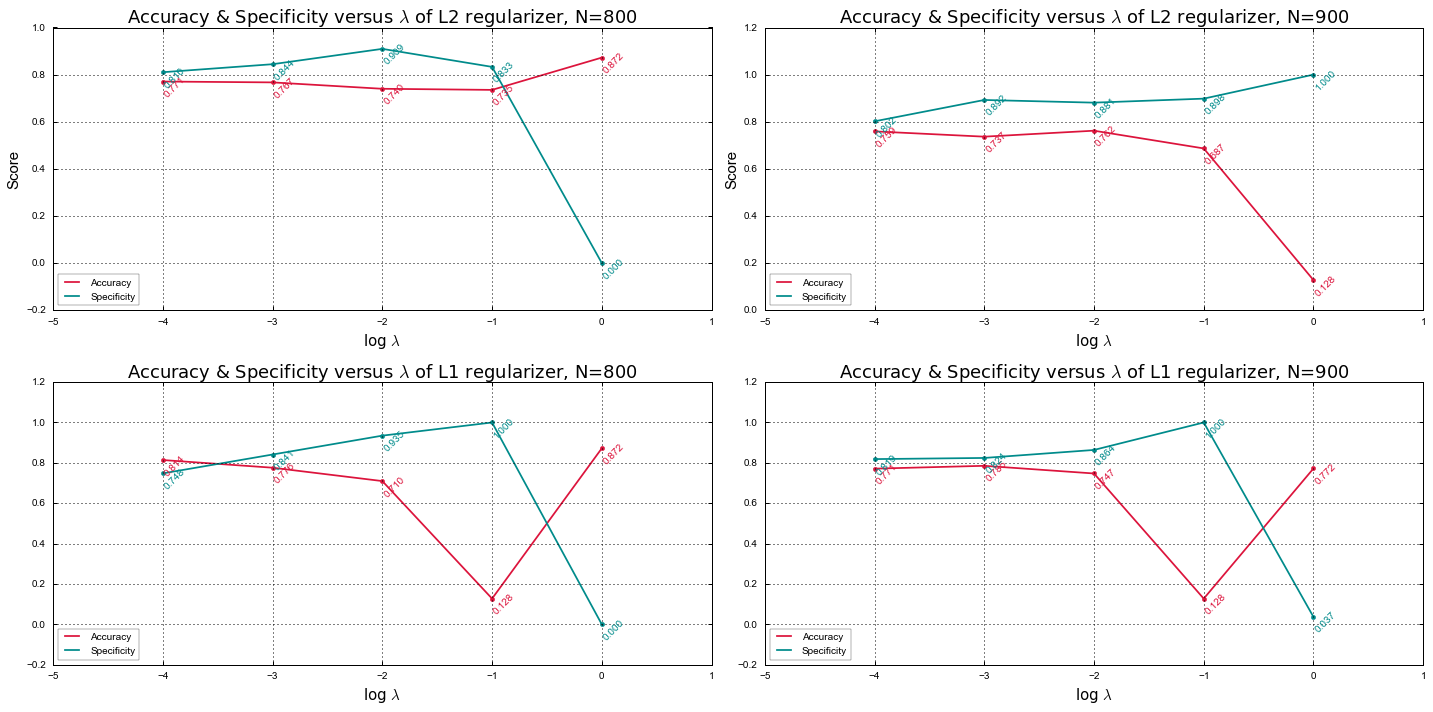

In [654]:
plt.style.use('seaborn-notebook')
plt.figure(figsize=(20,10))


plt.subplot(2,2,1)
rs_l2800_chosen.plot(color_acc='crimson',color_spe='darkcyan',label_acc='Accuracy',label_spe='Specificity')
plt.title('Accuracy & Specificity versus $\lambda$ of L2 regularizer, N=800', fontsize=18)
plt.xlabel('log $\lambda$',fontsize=15)
plt.ylabel('Score', fontsize=15)
plt.legend(loc='lower left')
plt.grid()

plt.subplot(2,2,2)
rs_l2900_chosen.plot(color_acc='crimson',color_spe='darkcyan',label_acc='Accuracy',label_spe='Specificity')

plt.title('Accuracy & Specificity versus $\lambda$ of L2 regularizer, N=900', fontsize=18)
plt.xlabel('log $\lambda$',fontsize=15)
plt.ylabel('Score', fontsize=15)
plt.legend(loc='lower left')
plt.grid()


plt.subplot(2,2,3)
rs_l1800_chosen.plot(color_acc='crimson',color_spe='darkcyan',label_acc='Accuracy',label_spe='Specificity')
plt.title('Accuracy & Specificity versus $\lambda$ of L1 regularizer, N=800', fontsize=18)        
plt.xlabel('log $\lambda$',fontsize=15)
plt.legend(loc='lower left')
plt.grid()

plt.subplot(2,2,4)
rs_l1900_chosen.plot(color_acc='crimson',color_spe='darkcyan',label_acc='Accuracy',label_spe='Specificity')

plt.title('Accuracy & Specificity versus $\lambda$ of L1 regularizer, N=900', fontsize=18)        
plt.xlabel('log $\lambda$',fontsize=15)
plt.legend(loc='lower left')
plt.grid()

plt.tight_layout()

## Label  Confusion Investigation

In [471]:
confused_labels = np.array(unpickle('confused_labels'))
confused_labels_chosen = np.array(unpickle('confused_labels_chosen'))
preds_tuned = np.array(unpickle('preds'))
preds_tuned_chosen = np.array(unpickle('preds_chosen'))

In [472]:
confused_junior = confused_labels[confused_labels<100]
true_confused_labels_junior = y_valid_labels[confused_junior]
legend_c = {0:'False Positive', 1:'False Negative'}

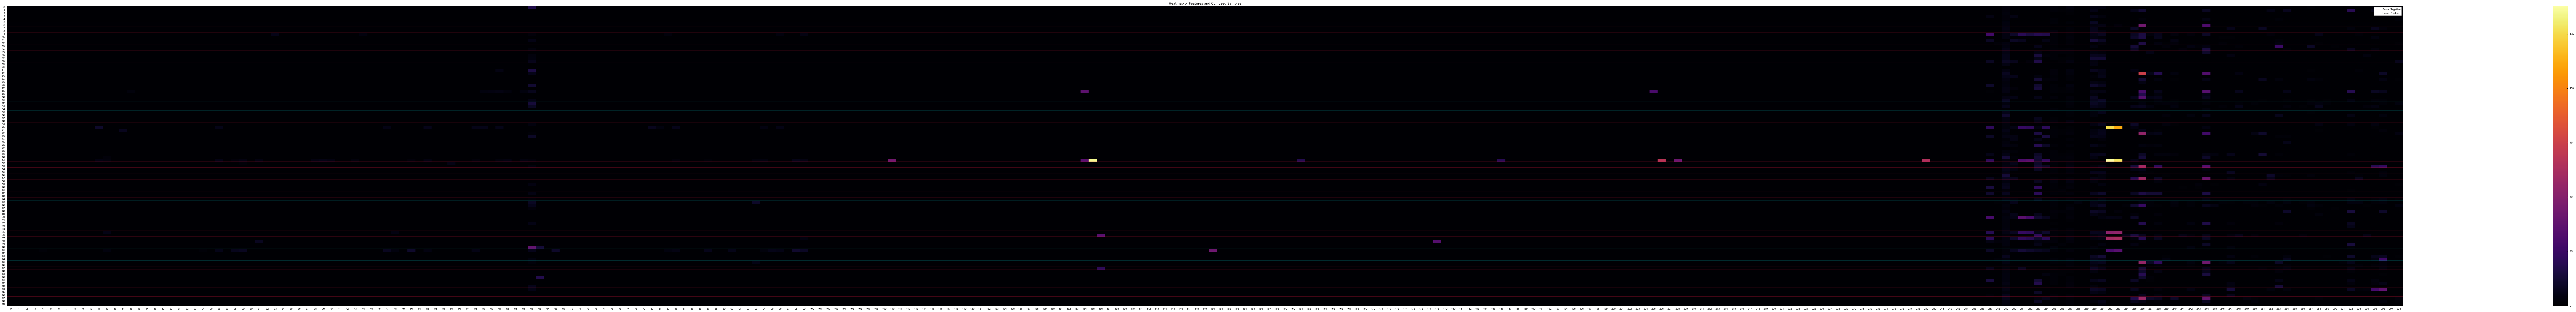

In [467]:
plt.figure(figsize=(200,20))
sns.heatmap(balanced_X[:100,:],cmap='inferno')
for entry in confused_junior:
    plt.plot([0,299],[entry]*2,alpha=.4, color=colors[3+true_confused_labels_junior[entry]],
            label=legend_c[true_confused_labels_junior[entry]] if (entry==3 or entry ==15) else None)
plt.legend()
plt.title('Heatmap of Features and Confused Samples')

## Correlation of feature vectors of confused samples, by label

In [10]:
model_all_layers = model_from_json(open('model_all_layers.json').read())
model_all_layers.load_weights('model_all_layers_weights.h5')

model_MLP = model_from_json(open('model_MLP.json').read())
model_MLP.load_weights('model_MLP_weights.h5')

In [ ]:
preds_all_training = model_all_layers.predict(balanced_X)
preds_mlp_training = model_MLP.predict(balanced_X)

In [12]:
preds_all_validation = model_all_layers.predict(X_valid)
preds_mlp_validation = model_MLP.predict(X_valid)

In [ ]:
preds_all_training_labels = model_all_layers.predict_classes(balanced_X)
preds_mlp_training_labels = model_MLP.predict_classes(balanced_X)

In [11]:
preds_all_validation_labels = model_all_layers.predict_classes(X_valid)
preds_mlp_validation_labels = model_MLP.predict_classes(X_valid)

2764/2764 [==============================] - 0s     


In [24]:
cm_all_training = confusion_matrix(balanced_y,preds_all_training_labels)
cm_mlp_training = confusion_matrix(balanced_y,preds_mlp_training_labels)

cm_all_validation = confusion_matrix(y_valid_labels,preds_all_validation_labels)
cm_mlp_validation = confusion_matrix(y_valid_labels,preds_mlp_validation_labels)

In [25]:
name_models_extentions = ['all_training','mlp_training','all_validation','mlp_validation']

In [26]:
def pretty_cm(cm, y_true, preds, name='name'):
    if (len(preds[preds==0]))!=0 :
        specificity = len(preds[(preds==0)&(y_true==0)])/(len(y_true[y_true==0]))
    else:
        specificity = 0
        
    sns.heatmap(cm, annot = True,fmt = 'd', annot_kws={"fontsize":20})
    plt.title('Confusion Matrix for {0}'.format(name), fontsize=30)
    plt.xlabel("Accuracy: {0:.2f} \nRecall: {1:.2f}\nSpecificity: {2:.2f}".format(accuracy_score(y_true,preds),
                                                                      recall_score(y_true, preds),
                                                                      specificity),fontsize= 20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

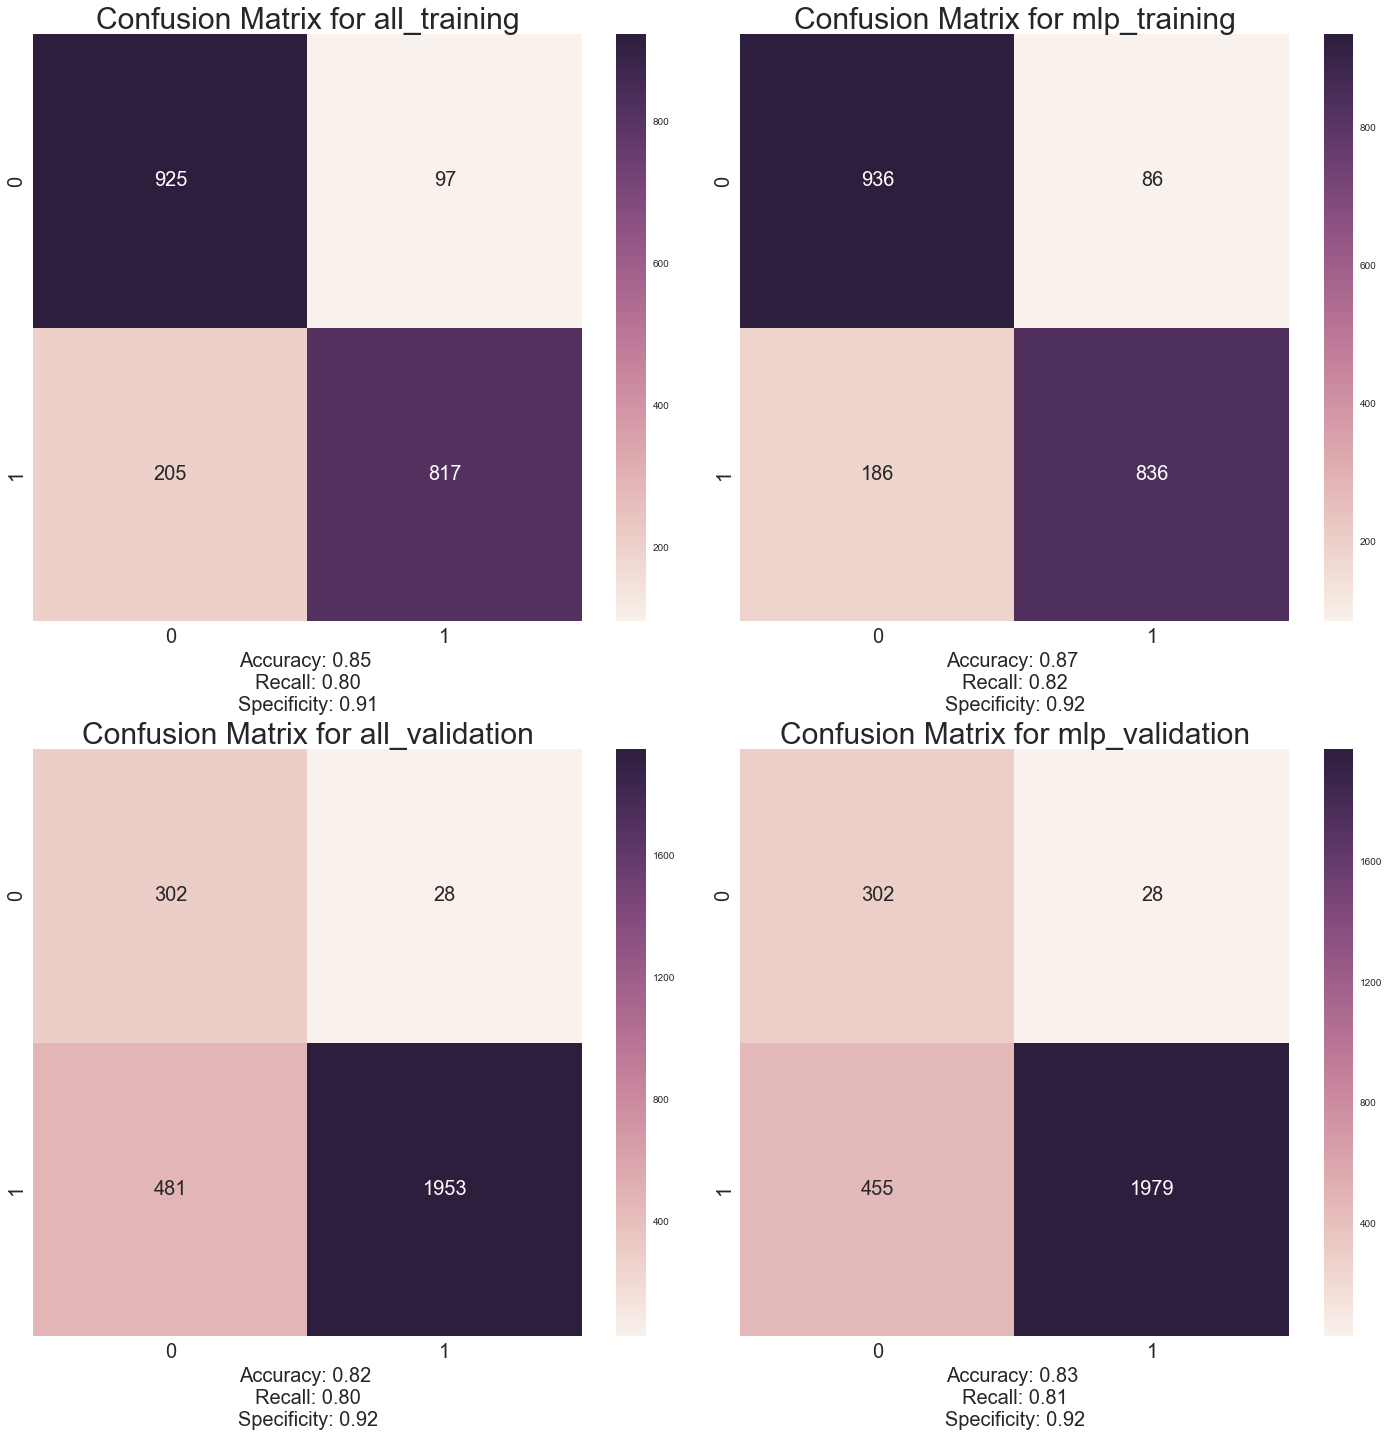

In [27]:
plt.figure(figsize=(20,20))
for i in range(2):
    plt.subplot(2,2,i+1)
    pretty_cm(eval('cm_'+name_models_extentions[i]),
              balanced_y,
              eval('preds_'+name_models_extentions[i]+'_labels'),
              name = name_models_extentions[i])
for i in [2,3]:
    plt.subplot(2,2,i+1)
    pretty_cm(eval('cm_'+name_models_extentions[i]),
              y_valid_labels.values,
              eval('preds_'+name_models_extentions[i]+'_labels'),
              name = name_models_extentions[i])
    
plt.tight_layout()

array([[ 290,   40],
       [ 410, 2024]])

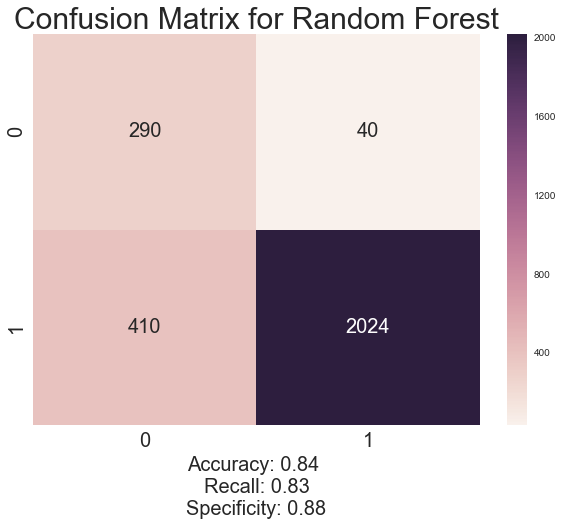

In [28]:
#Random forest again for comparision
assess(y_valid_labels.values,preds,'Random Forest')

In [29]:
def add_roc(fpr,tpr,p, name, color):
    # add a line renderer with legend and line thickness
    p.line(fpr, tpr, legend=name, line_width=2, color=color)
    return 

In [30]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_valid_labels,
                                          rf.predict_proba(X_valid)[:,1],
                                          pos_label=1)
fpr_all, tpr_all, thresholds_all = roc_curve(y_valid_labels,
                                             model_all_layers.predict_proba(X_valid)[:,1],
                                             pos_label=1)
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_valid_labels,
                                             model_MLP.predict_proba(X_valid)[:,1],
                                             pos_label=1)

2764/2764 [==============================] - 0s     


In [31]:
p = figure(title="ROC Curve for Classifiers", x_axis_label='1-Specificity', y_axis_label='Sensitiviy')

add_roc(fpr_rf, tpr_rf,p,
        'ROC for Random Forest, AUC:{0:.2f}'.format(auc(fpr_rf,tpr_rf)),
        '#27ae60')
add_roc(fpr_all, tpr_all,p,
        'ROC for Multi-Layered Network, AUC:{0:.2f}'.format(auc(fpr_all,tpr_all)),
        '#c0392b')
add_roc(fpr_mlp, tpr_mlp,p,
        'ROC for Single-Layered Network, AUC:{0:.2f}'.format(auc(fpr_mlp,tpr_mlp)),
        '#e67e22')

# show the results
p.legend.orientation='bottom_right'
show(p)

## Assessing the confused labels on the training set

In [192]:
#confused labels over all the models
confused_labels_rf = confused_oob
confused_labels_all = np.where(balanced_y != preds_all_training_labels)
confused_labels_mlp = np.where(balanced_y != preds_mlp_training_labels)

In [71]:
intersections = []
for entry in confused_labels_all[0]:
    if entry in confused_labels_mlp[0]:
        intersections.append(entry)

In [193]:
intersections_deep_rf = []
for entry in confused_labels_all[0]:
    if entry in confused_labels_rf[0]:
        intersections_deep_rf.append(entry)

In [194]:
intersections_mlp_rf = []
for entry in confused_labels_mlp[0]:
    if entry in confused_labels_rf[0]:
        intersections_mlp_rf.append(entry)

In [74]:
intersections = np.array(intersections)

In [191]:
print 'Number of shared confused labels over the deep network confused labels: {0:.2f}'.format(len(intersections)/len(confused_labels_all[0]))
print 'Number of shared confused labels over the shallow network confused labels: {0:.2f}'.format(len(intersections)/len(confused_labels_mlp[0]))

Number of shared confused labels over the deep network confused labels: 0.75
Number of shared confused labels over the shallow network confused labels: 0.84


In [209]:
print """Random Forest confused {0} samples on its OOB data, and the Deep Network confused {1} samples
on the training data. Of these {2} are common.\n""".format(len(confused_labels_rf[0]),
                                                         len(confused_labels_all[0]),
                                                         len(intersections_deep_rf))

print """\(^v^)/ \(^v^)/ \(^v^)/ \(^v^)/\n"""
print """Random Forest confused {0} samples on its OOB data, and the Shallow Network confused {1} samples on the training data. Of these {2} are common.\n
                                              """.format(len(confused_labels_rf[0]),
                                                         len(confused_labels_mlp[0]),
                                                         len(intersections_mlp_rf))

Random Forest confused 287 samples on its OOB data, and the Deep Network confused 302 samples
on the training data. Of these 168 are common.

\(^v^)/ \(^v^)/ \(^v^)/ \(^v^)/

Random Forest confused 287 samples on its OOB data, and the Shallow Network confused 272 samples on the training data. Of these 158 are common.

                                              


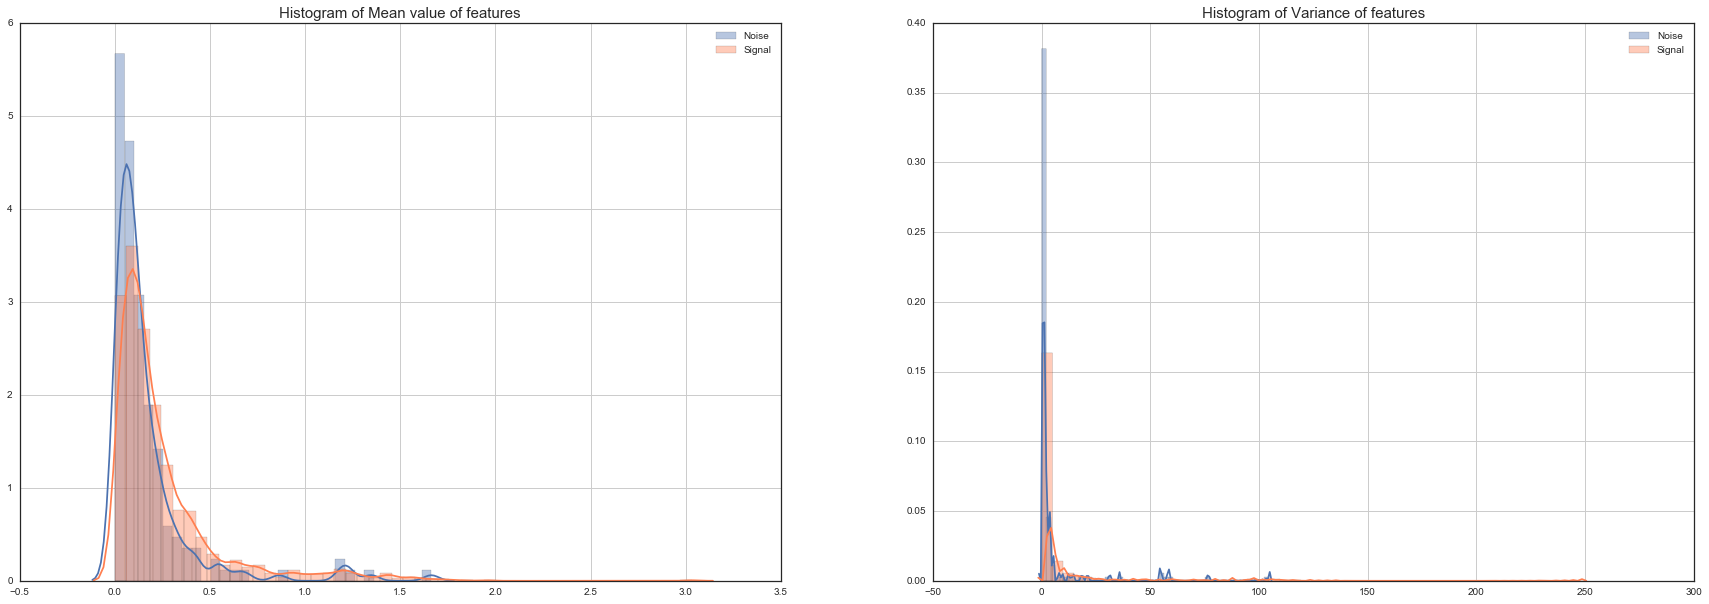

In [307]:
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
sns.distplot(np.mean(balanced_X[intersections_deep_rf,:],axis=1),label='Noise')
sns.distplot(np.mean(np.delete(balanced_X,np.array(intersections_deep_rf),axis=0), axis=1),
                     color="coral",label='Signal')
plt.title('Histogram of Mean value of features',fontsize=15)
plt.legend()
plt.grid()

plt.subplot(1,2,2)
sns.distplot(np.var(balanced_X[intersections_deep_rf,:],axis=1),label='Noise')
sns.distplot(np.var(np.delete(balanced_X,np.array(intersections_deep_rf),axis=0), axis=1),
                     color="coral",label='Signal')
plt.title('Histogram of Variance of features',fontsize=15)
plt.legend()
plt.grid()

In [197]:
len(intersections_mlp_rf)

158

In [94]:
confused_X_all = balanced_X[confused_labels_all,:][0]
confused_X_mlp = balanced_X[confused_labels_mlp,:][0]

confused_y_all = balanced_y.reshape(-1,1)[confused_labels_all,:][0]
confused_y_mlp = balanced_y.reshape(-1,1)[confused_labels_mlp,:][0]


con_X_all_train = confused_X_all[:int(.8*len(confused_X_all)),:]
con_X_all_valid = confused_X_all[int(.8*len(confused_X_all)):,:]
con_y_all_train = confused_y_all[:int(.8*len(confused_y_all)),:]
con_y_all_valid = confused_y_all[int(.8*len(confused_y_all)):,:]

con_X_mlp_train = confused_X_mlp[:int(.8*len(confused_X_mlp)),:]
con_X_mlp_valid = confused_X_mlp[int(.8*len(confused_X_mlp)):,:]
con_y_mlp_train = confused_y_mlp[:int(.8*len(confused_y_mlp)),:]
con_y_mlp_valid = confused_y_mlp[int(.8*len(confused_y_mlp)):,:]

In [85]:
from sklearn.linear_model import LogisticRegression

In [97]:
lr_all = LogisticRegression()
lr_mlp = LogisticRegression()

lr_all.fit(con_X_all_train,con_y_all_train.ravel())
lr_mlp.fit(con_X_mlp_train,con_y_mlp_train.ravel())

conf_preds_all_labels = lr_all.predict(con_X_all_valid)
conf_preds_mlp_labels = lr_mlp.predict(con_X_mlp_valid)

conf_preds_all_prob = lr_all.predict_proba(con_X_all_valid)
conf_preds_mlp_prob = lr_mlp.predict_proba(con_X_mlp_valid)

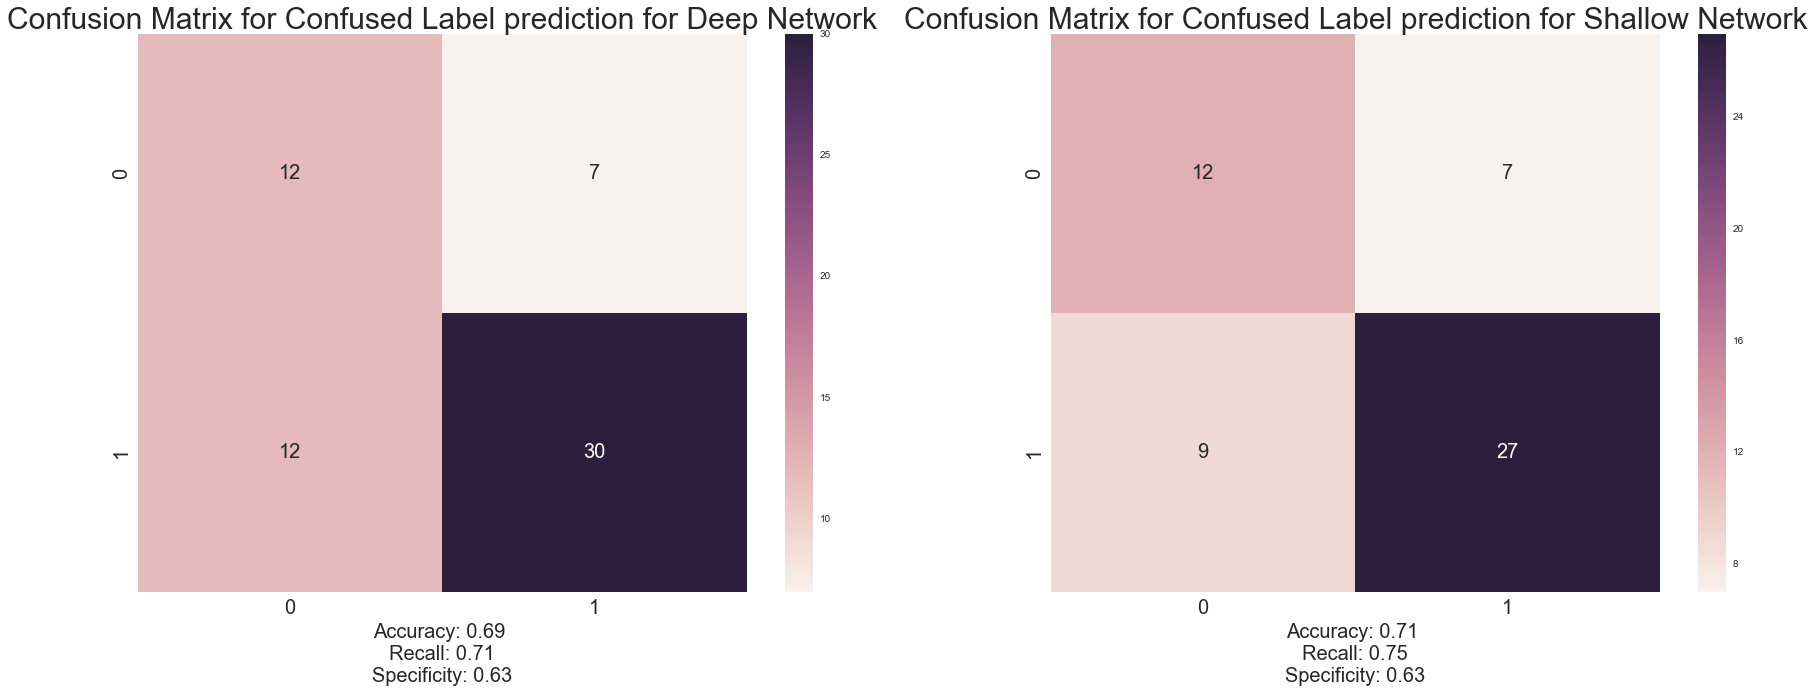

In [110]:
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
pretty_cm(confusion_matrix(con_y_all_valid.ravel(),conf_preds_all_labels),
                           con_y_all_valid.ravel(),
                           conf_preds_all_labels,
                           'Confused Label prediction for Deep Network')

plt.subplot(1,2,2)
pretty_cm(confusion_matrix(con_y_mlp_valid.ravel(),conf_preds_mlp_labels),
                           con_y_mlp_valid.ravel(),
                           conf_preds_mlp_labels,
                           'Confused Label prediction for Shallow Network')

<h2 style="color:lightskyblue"> Stability </h2>

In [119]:
#Creating keys for the model dictionary
keys_for_models = ['models_all_layers_%s'%i for i in range(10)]+['models_mlp_%s'%i for i in range(10)]

In [120]:
all_models = {keys_for_models[i]:None for i in range(20)}

In [121]:
#Getting a Distribution for the full model
#Loading the models
for i in range(10):
    all_models['models_all_layers_%s'%i] = model_from_json(open('models_all_layers_%s.json'%i).read())
    all_models['models_all_layers_%s'%i].load_weights('models_all_layers_%s_weights.h5'%i)

    all_models['models_mlp_%s'%i] = model_from_json(open('models_mlp_%s.json'%i).read())
    all_models['models_mlp_%s'%i].load_weights('models_mlp_%s_weights.h5'%i)

In [122]:
#Creating keys for class prediction dictionary
keys_for_preds = ['preds_all_%s'%i for i in range(10)]+['preds_mlp_%s'%i for i in range(10)]

In [123]:
all_preds = {keys_for_preds[i]:None for i in range(20)}

In [124]:
for i in range(10):
    all_preds['preds_all_%s'%i] = all_models['models_all_layers_%s'%i].predict_classes(X_valid,
                                                                                      verbose=0)
    all_preds['preds_mlp_%s'%i] = all_models['models_mlp_%s'%i].predict_classes(X_valid,
                                                                               verbose=0)

In [125]:
base_labels_all = all_preds['preds_all_0']
base_labels_mlp = all_preds['preds_mlp_0']

In [126]:
#creating the metric dictionary
metric = {'all': [], 'mlp':[]}
#using xor means how many changed, compared to the base case
for i in range(1,9):
    metric['all'].append(sum([j^k for j,k in zip(base_labels_all,all_preds['preds_all_%s'%i])]))
    metric['mlp'].append(sum([j^k for j,k in zip(base_labels_mlp,all_preds['preds_mlp_%s'%i])]))

In [127]:
metric

{'all': [120, 144, 149, 117, 167, 150, 174, 152],
 'mlp': [135, 146, 206, 160, 154, 152, 226, 133]}

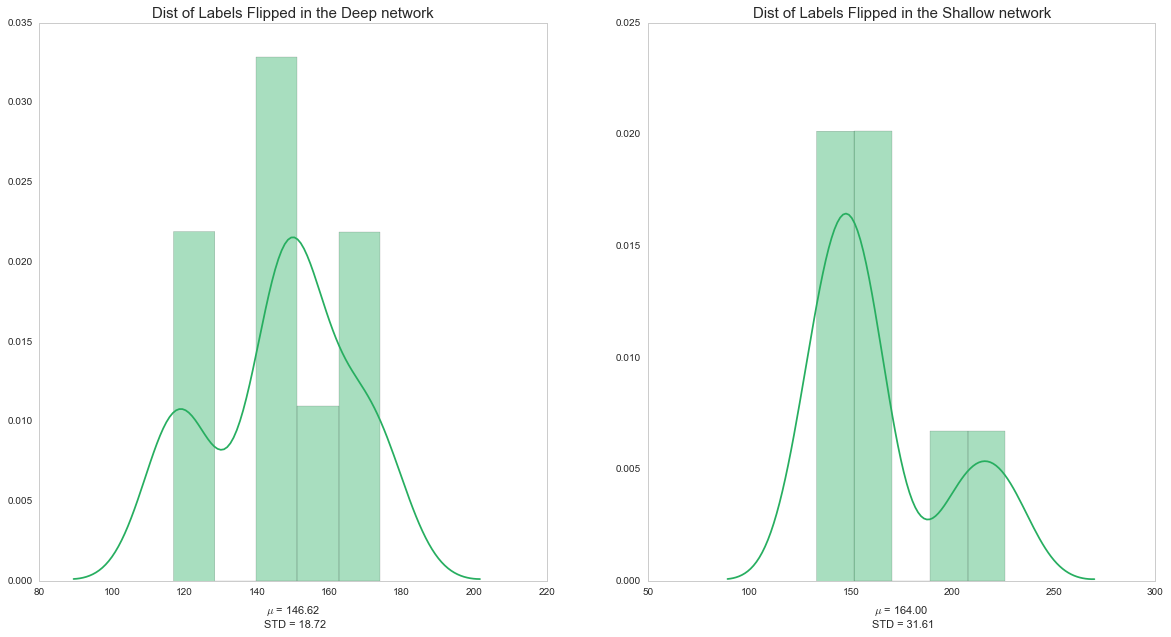

In [149]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
sns.distplot(metric['all'], color = '#27ae60', bins=5)

all_mean = np.mean(metric['all'])
all_std = np.std(metric['all'])
plt.title('Dist of Labels Flipped in the Deep network', fontsize=15)
plt.xlabel('$\mu$ = {0:.2f} \n STD = {1:.2f}'.format(all_mean, all_std))
plt.grid(False)

plt.subplot(1,2,2)
sns.distplot(metric['mlp'], color = '#27ae60',bins=5)

mlp_mean = np.mean(metric['mlp'])
mlp_std = np.std(metric['mlp'])
plt.title('Dist of Labels Flipped in the Shallow network', fontsize=15)
plt.xlabel('$\mu$ = {0:.2f} \n STD = {1:.2f}'.format(mlp_mean,mlp_std))
plt.grid(False)

## The perturbed Models

In [134]:
# dof = 8, => t-stat coef = 1.860 for 95% of the data
#Creating keys for the model dictionary
keys_for_models_perturbed = ['models_all_layers_perturbed_%s'%i for i in range(10)]+['models_mlp_perturbed_%s'%i for i in range(10)]

In [135]:
all_models_perturbed = {keys_for_models[i]:None for i in range(20)}

In [136]:
#Getting a Distribution for the full model
#Loading the models
for i in range(10):
    all_models_perturbed['models_all_layers_perturbed_%s'%i] = model_from_json(open('models_all_layers_perturbed_%s.json'%i).read())
    all_models_perturbed['models_all_layers_perturbed_%s'%i].load_weights('models_all_layers_perturbed_%s_weights.h5'%i)

    all_models_perturbed['models_mlp_perturbed_%s'%i] = model_from_json(open('models_mlp_perturbed_%s.json'%i).read())
    all_models_perturbed['models_mlp_perturbed_%s'%i].load_weights('models_mlp_perturbed_%s_weights.h5'%i)

In [141]:
#Creating keys for class prediction dictionary
keys_for_preds_p = ['preds_all_p_%s'%i for i in range(10)]+['preds_mlp_p_%s'%i for i in range(10)]

In [142]:
all_preds_p = {keys_for_preds[i]:None for i in range(20)}

In [143]:
for i in range(10):
    all_preds_p['preds_all_p_%s'%i] = all_models_perturbed['models_all_layers_perturbed_%s'%i].predict_classes(X_valid,
                                                                                      verbose=0)
    all_preds_p['preds_mlp_p_%s'%i] = all_models_perturbed['models_mlp_perturbed_%s'%i].predict_classes(X_valid,
                                                                               verbose=0)

In [144]:
#creating the metric dictionary
metric_p = {'all_p': [], 'mlp_p':[]}
#using xor means how many changed, compared to the base case
for i in range(1,9):
    metric_p['all_p'].append(sum([j^k for j,k in zip(base_labels_all,all_preds_p['preds_all_p_%s'%i])]))
    metric_p['mlp_p'].append(sum([j^k for j,k in zip(base_labels_mlp,all_preds_p['preds_mlp_p_%s'%i])]))

In [151]:
metric_p

{'all_p': [243, 330, 227, 283, 237, 307, 201, 310],
 'mlp_p': [190, 283, 217, 318, 238, 288, 229, 282]}

In [160]:
stats = {'all_p':{'yes_replacement':{'mean':0,'std':0}, 'no_replacement':{'mean':0,'std':0}},
         'mlp_p':{'yes_replacement':{'mean':0,'std':0}, 'no_replacement':{'mean':0,'std':0}}}

In [161]:
for model_type in stats:
    for sample_type in stats[model_type]:
        if sample_type=='yes_replacement':
            stats[model_type][sample_type]['mean'] = np.mean([x for i,x in enumerate(metric_p[model_type]) if i%2==0])
            stats[model_type][sample_type]['std'] = np.std([x for i,x in enumerate(metric_p[model_type]) if i%2==0])
        else:
            stats[model_type][sample_type]['mean'] = np.mean([x for i,x in enumerate(metric_p[model_type]) if i%2==1])
            stats[model_type][sample_type]['std'] = np.std([x for i,x in enumerate(metric_p[model_type]) if i%2==1])

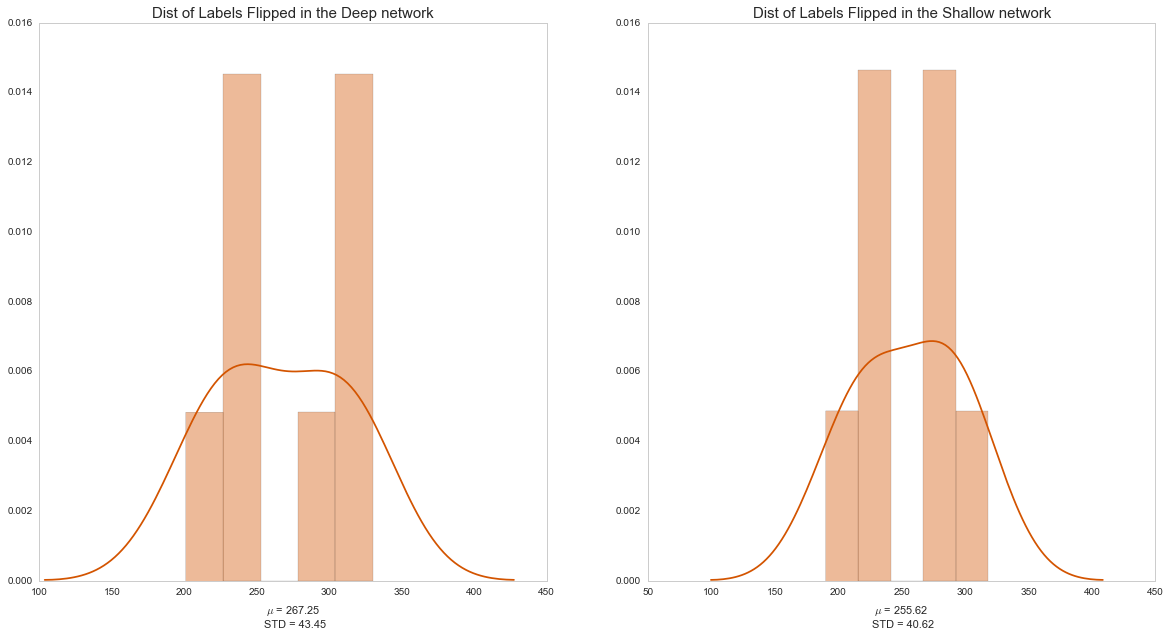

In [150]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
sns.distplot(metric_p['all_p'], color = '#d35400', bins=5)

all_mean_p = np.mean(metric_p['all_p'])
all_std_p = np.std(metric_p['all_p'])
plt.title('Dist of Labels Flipped in the Deep network', fontsize=15)
plt.xlabel('$\mu$ = {0:.2f} \n STD = {1:.2f}'.format(all_mean_p,all_std_p))
plt.grid(False)

plt.subplot(1,2,2)
sns.distplot(metric_p['mlp_p'], color = '#d35400',bins=5)

mlp_mean_p = np.mean(metric_p['mlp_p'])
mlp_std_p = np.std(metric_p['mlp_p'])
plt.title('Dist of Labels Flipped in the Shallow network', fontsize=15)
plt.xlabel('$\mu$ = {0:.2f} \n STD = {1:.2f}'.format(mlp_mean_p,mlp_std_p))
plt.grid(False)

In [163]:
# H0 : u_1 = u_2. 
#With replacement
all_std_pooled_w = (all_std**2+stats['all_p']['yes_replacement']['std']**2)**.5
mlp_std_pooled_w = (mlp_std**2+stats['mlp_p']['yes_replacement']['std']**2)**.5

#dof : 15 - 1 = 14 => t-table : 1.761
CI_all_w = 1.761 * all_std_pooled_w / (15)**.5
CI_mlp_w = 1.761 * mlp_std_pooled_w / (15)**.5

#With replacement
all_std_pooled_o = (all_std**2+stats['all_p']['no_replacement']['std']**2)**.5
mlp_std_pooled_o = (mlp_std**2+stats['mlp_p']['no_replacement']['std']**2)**.5

#dof : 15 - 1 = 14 => t-table : 1.761
CI_all_o = 1.761 * all_std_pooled_o / (15)**.5
CI_mlp_o = 1.761 * mlp_std_pooled_o / (15)**.5


In [174]:
diff_w_all = np.abs(all_mean - stats['all_p']['yes_replacement']['mean'])
print 'With Replacement Deep Network'
print 'Mean Base = {0:.2f}, Mean Sample = {1:.2f}, Difference = {2:.2f}'.format(all_mean,
                                                                    stats['all_p']['yes_replacement']['mean'],
                                                                    diff_w_all)

                                                                    
print "CI:{0:.2f}".format(CI_all_w)
print "="*20
if diff_w_all > CI_all_w: 
    print "Rejecting Null" 
else: 
    print "Accepting Null"
    
print "*"*20
print "*"*20

diff_w_mlp = np.abs(mlp_mean - stats['mlp_p']['yes_replacement']['mean'])
print 'With Replacement Shallow Network'
print 'Mean Base = {0:.2f}, Mean Sample = {1:.2f}, Difference = {2:.2f}'.format(mlp_mean,
                                                                    stats['mlp_p']['yes_replacement']['mean'],
                                                                    diff_w_mlp)

                                                                    
print "CI:{0:.2f}".format(CI_mlp_w)
print "="*20
if diff_w_mlp > CI_mlp_w: 
    print "Rejecting Null" 
else: 
    print "Accepting Null"                                                                  
                            

With Replacement Deep Network
Mean Base = 146.62, Mean Sample = 227.00, Difference = 80.38
CI:11.22
Rejecting Null
********************
********************
With Replacement Shallow Network
Mean Base = 164.00, Mean Sample = 218.50, Difference = 54.50
CI:16.55
Rejecting Null


In [176]:
#No replacement
diff_o_all = np.abs(all_mean - stats['all_p']['no_replacement']['mean'])
print 'Without Replacement Deep Network'
print 'Mean Base = {0:.2f}, Mean Sample = {1:.2f}, Difference = {2:.2f}'.format(all_mean,
                                                                    stats['all_p']['no_replacement']['mean'],
                                                                    diff_o_all)

                                                                    
print "CI:{0:.2f}".format(CI_all_o)
print "="*20
if diff_o_all > CI_all_o: 
    print "Rejecting Null" 
else: 
    print "Accepting Null"
    
print "*"*20
print "*"*20

diff_o_mlp = np.abs(mlp_mean - stats['mlp_p']['no_replacement']['mean'])
print 'Without Replacement Shallow Network'
print 'Mean Base = {0:.2f}, Mean Sample = {1:.2f}, Difference = {2:.2f}'.format(mlp_mean,
                                                                    stats['mlp_p']['no_replacement']['mean'],
                                                                    diff_o_mlp)

                                                                    
print "CI:{0:.2f}".format(CI_mlp_o)
print "="*20
if diff_o_mlp > CI_mlp_o: 
    print "Rejecting Null" 
else: 
    print "Accepting Null"                                                                  
                            

Without Replacement Deep Network
Mean Base = 146.62, Mean Sample = 307.50, Difference = 160.88
CI:11.40
Rejecting Null
********************
********************
With Replacement Shallow Network
Mean Base = 164.00, Mean Sample = 292.75, Difference = 128.75
CI:15.86
Rejecting Null


## Random Forest Stability

In [212]:
rf_stable_all = []
for i in range(10):
    clf = RandomForestClassifier(n_estimators=50)
    clf.fit(balanced_X, balanced_y)
    rf_stable_all.append(clf.predict(X_valid))
    
rf_stable_sampled = []
for i in range(10):
    random_indices = np.random.choice(range(len(balanced_X)), int(.7*len(balanced_X)))
    clf = RandomForestClassifier(n_estimators=50)
    clf.fit(balanced_X[random_indices], balanced_y[random_indices])
    rf_stable_sampled.append(clf.predict(X_valid))
    

In [213]:
base_rf = rf_stable_all[0]
changed_all = []
for forest in rf_stable_all:
    changed_all.append([j^k for j,k in zip(forest,base_rf)])

changed_sampled = []
for forest in rf_stable_sampled:
    changed_sampled.append([j^k for j,k in zip(forest,base_rf)])    

In [218]:
mean_rf_all = np.mean(changed_all)
mean_rf_sampled = np.mean(changed_sampled)

std_rf_all = np.std(changed_all)
std_rf_sampled = np.std(changed_sampled)

In [219]:
#1.729
CI = 1.729 * (std_rf_all**2 + std_rf_sampled**2)**.5/(20)**.5
print CI
print np.abs(mean_rf_sampled-mean_rf_all)

0.119120618385
0.0229377713459


## Testing the confusion matrix for each model

In [19]:
accuracy_all_models = []
for item in all_preds:
    accuracy_all_models.append(accuracy_score(y_valid_labels,all_preds[item]))


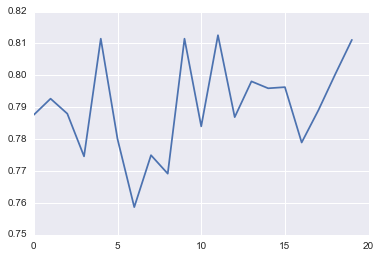

In [22]:
plt.plot(accuracy_all_models)

<h2 style="color:lightskyblue"> Boosting the model with Confused samples </h2>

In [202]:
model_to_boost = model_from_json(open('models_all_layers_0.json').read())
model_to_boost.load_weights('models_all_layers_0_weights.h5')

model_to_boost.compile(SGD(lr=0.00001,
                           momentum=.6,
                           decay=1e-6,
                           nesterov=True),
                           loss='categorical_crossentropy')

In [203]:
weighting_comparison_predictions = []
weighting_comparison_predictions_training = []
confused_indices_collection = []

In [204]:
#First to get the confused classes
for i in range(20):
    #validation
    weighted_preds = model_to_boost.predict_classes(X_valid, verbose = 0)
    weighting_comparison_predictions.append(weighted_preds)
    
    #training
    weighted_preds_train = model_to_boost.predict_classes(balanced_X, verbose = 0)
    weighting_comparison_predictions_training.append(weighted_preds_train)
    
    confused_weighted_indices_train = np.where(weighted_preds_train!=balanced_y)
    confused_indices_collection.append(confused_weighted_indices_train)
    model_to_boost.fit(balanced_X[confused_weighted_indices_train],
                       balanced_y_hot[confused_weighted_indices_train],verbose=0,nb_epoch=100)

In [205]:
confusion_weighted = [confusion_matrix(y_valid_labels, preds) for preds in weighting_comparison_predictions]
confusion_weighted_training = [confusion_matrix(balanced_y, preds) for preds in weighting_comparison_predictions_training]

In [206]:
for entry,entry_t in zip(confusion_weighted,confusion_weighted_training):
    print "Validation:\n{0}\n\nTraining:\n{1}\n\n".format(entry, entry_t),'='*15,'\n'

Validation:
[[ 302   51]
 [ 507 1904]]

Training:
[[984  18]
 [ 80 922]]


Validation:
[[ 267   86]
 [ 402 2009]]

Training:
[[941  61]
 [ 51 951]]


Validation:
[[ 291   62]
 [ 447 1964]]

Training:
[[970  32]
 [ 59 943]]


Validation:
[[ 272   81]
 [ 414 1997]]

Training:
[[946  56]
 [ 49 953]]


Validation:
[[ 288   65]
 [ 458 1953]]

Training:
[[967  35]
 [ 59 943]]


Validation:
[[ 280   73]
 [ 436 1975]]

Training:
[[952  50]
 [ 49 953]]


Validation:
[[ 284   69]
 [ 450 1961]]

Training:
[[964  38]
 [ 54 948]]


Validation:
[[ 283   70]
 [ 441 1970]]

Training:
[[952  50]
 [ 50 952]]


Validation:
[[ 289   64]
 [ 460 1951]]

Training:
[[967  35]
 [ 54 948]]


Validation:
[[ 283   70]
 [ 445 1966]]

Training:
[[952  50]
 [ 47 955]]


Validation:
[[ 288   65]
 [ 464 1947]]

Training:
[[971  31]
 [ 54 948]]


Validation:
[[ 282   71]
 [ 443 1968]]

Training:
[[947  55]
 [ 49 953]]


Validation:
[[ 289   64]
 [ 464 1947]]

Training:
[[969  33]
 [ 52 950]]


Validation:
[[ 281   72]


In [207]:
accuracies_w = [(x[0][0]+x[1][1])/np.sum(x) for x in confusion_weighted]
specificities_w = [x[0][0]/(x[0][0]+x[0][1]) for x in confusion_weighted]

accuracies_w_t = [(x[0][0]+x[1][1])/np.sum(x) for x in confusion_weighted_training]
specificities_w_t = [x[0][0]/(x[0][0]+x[0][1]) for x in confusion_weighted_training]

(0, 30)

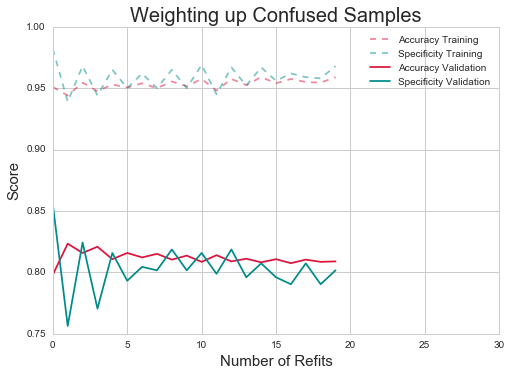

In [209]:
plt.style.use('seaborn-whitegrid')
plt.plot(accuracies_w_t, color = 'crimson',linestyle='--', alpha=.5, label="Accuracy Training")
plt.plot(specificities_w_t, color = 'darkcyan', linestyle='--',alpha=.5, label="Specificity Training")

plt.plot(accuracies_w, color = 'crimson', label = 'Accuracy Validation')
plt.plot(specificities_w, color = 'darkcyan', label = 'Specificity Validation')

plt.title('Weighting up Confused Samples',fontsize=20)
plt.xlabel('Number of Refits',fontsize=15)
plt.ylabel('Score',fontsize=15)
plt.legend()
plt.grid(True)
plt.xlim(0,30)


## ESCV

In [250]:
stability_deep = unpickle('stability_deep')
stability_shallow = unpickle('stability_shallow')
stability_rf = unpickle('stability_rf')

In [345]:
stability_deep = np.array(stability_deep)
stability_shallow = np.array(stability_shallow)
stability_rf = np.array(stability_rf)

x = stability_deep[:,0]
acc_deep = stability_deep[:,1]
acc_shallow = stability_shallow[:,1]
acc_rf = stability_rf[:,1]

spe_deep = stability_deep[:,2]
spe_shallow = stability_shallow[:,2]
spe_rf = stability_rf[:,2]

ES_deep = stability_deep[:,3]
ES_shallow = stability_shallow[:,3]
ES_rf = stability_rf[:,3]

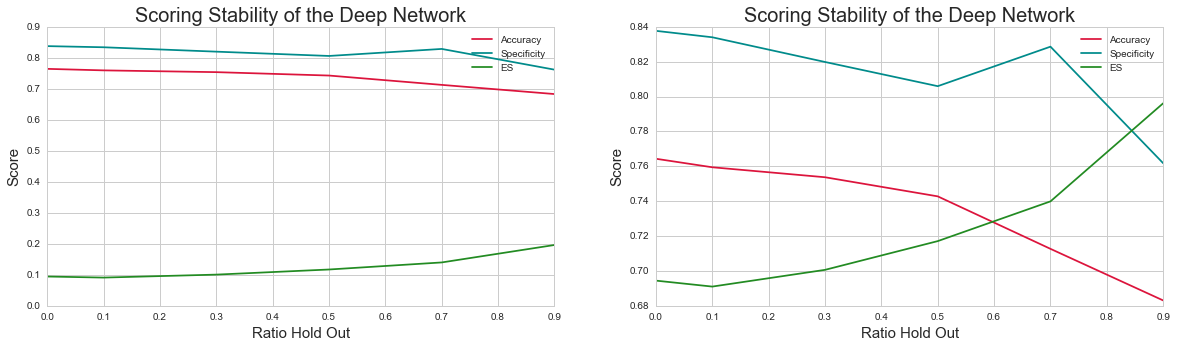

In [249]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.title('Scoring Stability of the Deep Network', fontsize=20)
plt.plot(x , acc_deep, color = 'crimson', label='Accuracy')
plt.plot(x , spe_deep, color = 'darkcyan', label='Specificity')
plt.plot(x , ES_deep, color = 'forestgreen', label='ES')
plt.xlabel('Ratio Hold Out', fontsize=15)
plt.ylabel('Score', fontsize=15)
plt.legend()

plt.subplot(1,2,2)
plt.title('Scoring Stability of the Deep Network', fontsize=20)
plt.plot(x , acc_deep, color = 'crimson', label='Accuracy')
plt.plot(x , spe_deep, color = 'darkcyan', label='Specificity')
plt.plot(x , ES_deep+.6, color = 'forestgreen', label='ES')
plt.xlabel('Ratio Hold Out', fontsize=15)
plt.ylabel('Score', fontsize=15)
plt.legend()

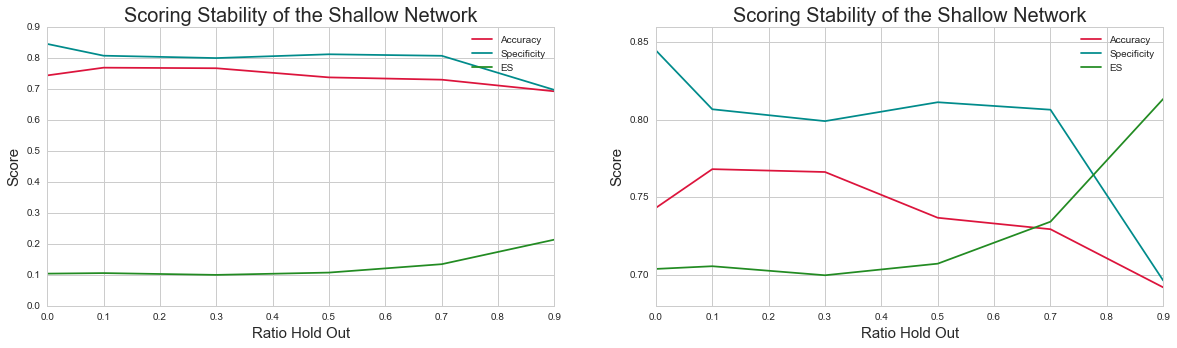

In [248]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.title('Scoring Stability of the Shallow Network', fontsize=20)
plt.plot(x , acc_shallow, color = 'crimson', label='Accuracy')
plt.plot(x , spe_shallow, color = 'darkcyan', label='Specificity')
plt.plot(x , ES_shallow, color = 'forestgreen', label='ES')
plt.xlabel('Ratio Hold Out', fontsize=15)
plt.ylabel('Score', fontsize=15)
plt.legend()

plt.subplot(1,2,2)
plt.title('Scoring Stability of the Shallow Network', fontsize=20)
plt.plot(x , acc_shallow, color = 'crimson', label='Accuracy')
plt.plot(x , spe_shallow, color = 'darkcyan', label='Specificity')
plt.plot(x , ES_shallow+.6, color = 'forestgreen', label='ES')
plt.xlabel('Ratio Hold Out', fontsize=15)
plt.ylabel('Score', fontsize=15)
plt.legend()

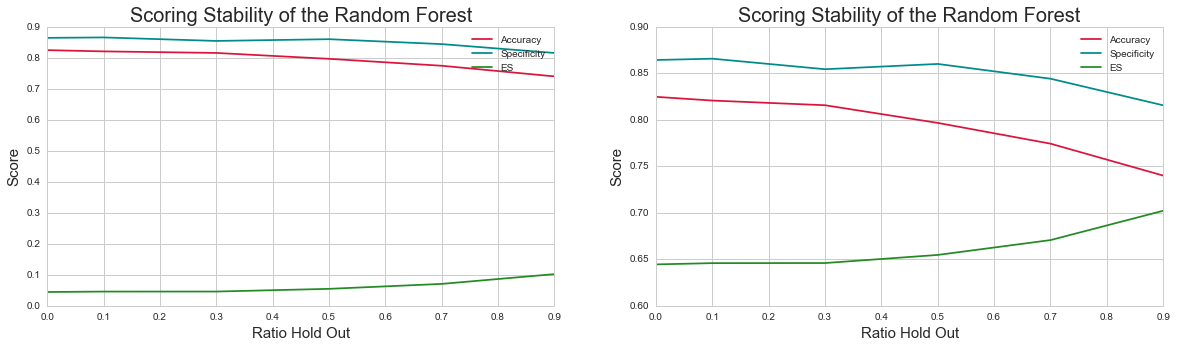

In [252]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.title('Scoring Stability of the Random Forest', fontsize=20)
plt.plot(x , acc_rf, color = 'crimson', label='Accuracy')
plt.plot(x , spe_rf, color = 'darkcyan', label='Specificity')
plt.plot(x , ES_rf, color = 'forestgreen', label='ES')
plt.xlabel('Ratio Hold Out', fontsize=15)
plt.ylabel('Score', fontsize=15)
plt.legend()

plt.subplot(1,2,2)
plt.title('Scoring Stability of the Random Forest', fontsize=20)
plt.plot(x , acc_rf, color = 'crimson', label='Accuracy')
plt.plot(x , spe_rf, color = 'darkcyan', label='Specificity')
plt.plot(x , ES_rf+.6, color = 'forestgreen', label='ES')
plt.xlabel('Ratio Hold Out', fontsize=15)
plt.ylabel('Score', fontsize=15)
plt.legend()

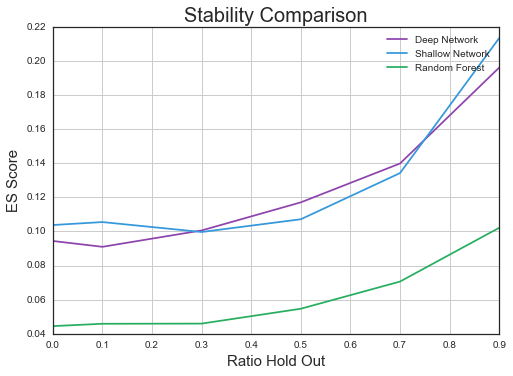

In [355]:
plt.title('Stability Comparison', fontsize=20)
plt.plot(x , ES_deep, color = '#8e44ad', label='Deep Network')
plt.plot(x , ES_shallow, color = '#3498db', label='Shallow Network')
plt.plot(x , ES_rf, color = '#27ae60', label='Random Forest')
plt.xlabel('Ratio Hold Out', fontsize=15)
plt.ylabel('ES Score', fontsize=15)
plt.legend()
plt.grid()

## Correcting for number of Samples

In [341]:
ns = [int(len(balanced_X)*x) for x in np.array([10]+range(9,0,-2))*.1]
ds = [np.floor(n/10) for n in ns]

In [342]:
coeffs_to_Z = [(n-d)/d for n,d in zip(ns,ds)]

In [343]:
Zs_deep = stability_deep[:,3]*coeffs_to_Z
Zs_shallow = stability_shallow[:,3]*coeffs_to_Z
Zs_rf = stability_rf[:,3]*coeffs_to_Z

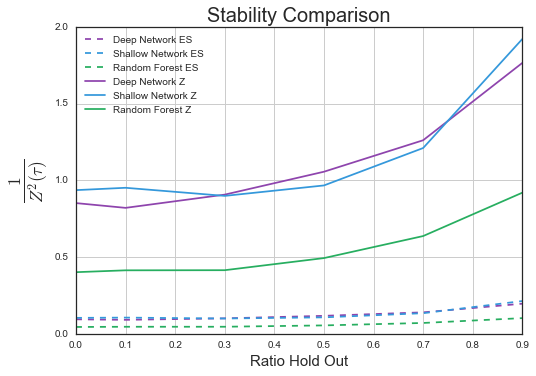

In [351]:
plt.plot(x , ES_deep, color = '#8e44ad', label='Deep Network ES', linestyle='--')
plt.plot(x , ES_shallow, color = '#3498db', label='Shallow Network ES', linestyle='--')
plt.plot(x , ES_rf, color = '#27ae60', label='Random Forest ES', linestyle='--')



plt.title('Stability Comparison', fontsize=20)
plt.plot(x , Zs_deep, color = '#8e44ad', label='Deep Network Z')
plt.plot(x , Zs_shallow, color = '#3498db', label='Shallow Network Z')
plt.plot(x , Zs_rf, color = '#27ae60', label='Random Forest Z')
plt.xlabel('Ratio Hold Out', fontsize=15)
plt.ylabel(r'$\frac{1}{Z^2(\tau)}$', fontsize=25)
plt.legend(loc='upper left')
plt.grid()

In [8]:
stability_deep = unpickle('deep_kf')
stability_shallow = unpickle('shallow_kf')
stability_rf = unpickle('rf_results_kf')

In [37]:
stability_deep = np.array(stability_deep)
stability_shallow = np.array(stability_shallow)
stability_rf = np.array(stability_rf)

x = stability_deep[:,0]
acc_deep = stability_deep[:,1]
acc_shallow = stability_shallow[:,1]
acc_rf = stability_rf[:,1]

spe_deep = stability_deep[:,2]
spe_shallow = stability_shallow[:,2]
spe_rf = stability_rf[:,2]

ES_deep = stability_deep[:,1]
ES_shallow = stability_shallow[:,1]
ES_rf = stability_rf[:,1]

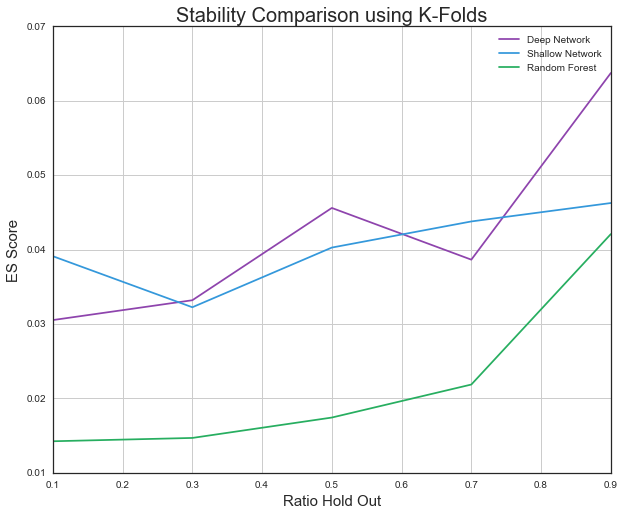

In [57]:
plt.style.use('seaborn-white')
plt.figure(figsize=(10,8))
plt.title('Stability Comparison using K-Folds', fontsize=20)
plt.plot(x , ES_deep, color = '#8e44ad', label='Deep Network')
plt.plot(x , ES_shallow, color = '#3498db', label='Shallow Network')
plt.plot(x , ES_rf, color = '#27ae60', label='Random Forest')
plt.xlabel('Ratio Hold Out', fontsize=15)
plt.ylabel('ES Score', fontsize=15)
plt.xlim(0.1,.9)
plt.legend()
plt.grid(True)

In [32]:
ns = [int(len(balanced_X)*x) for x in np.array(range(9,0,-2))*.1]
ds = [np.floor(n/10) for n in ns]

In [33]:
coeffs_to_Z = [(n-d)/d for n,d in zip(ns,ds)]

In [50]:
Zs_deep = stability_deep[:,1]*coeffs_to_Z
Zs_shallow = stability_shallow[:,1]*coeffs_to_Z
Zs_rf = stability_rf[:,1]*coeffs_to_Z

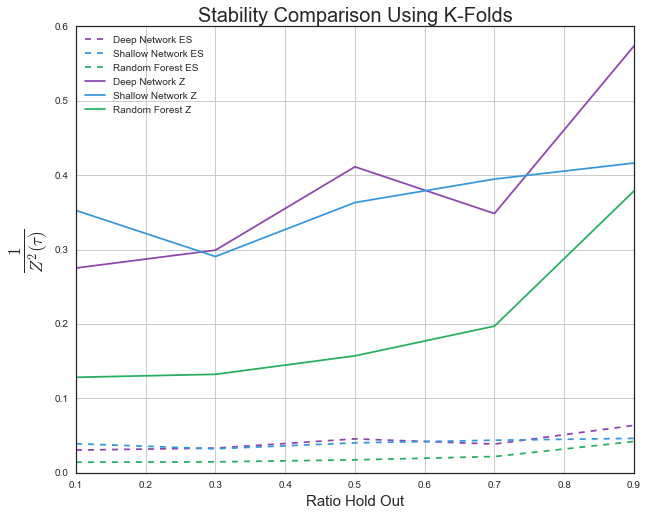

In [58]:
plt.figure(figsize=(10,8))
plt.plot(x , ES_deep, color = '#8e44ad', label='Deep Network ES', linestyle='--')
plt.plot(x , ES_shallow, color = '#3498db', label='Shallow Network ES', linestyle='--')
plt.plot(x , ES_rf, color = '#27ae60', label='Random Forest ES', linestyle='--')



plt.title('Stability Comparison Using K-Folds', fontsize=20)
plt.plot(x , Zs_deep, color = '#8e44ad', label='Deep Network Z')
plt.plot(x , Zs_shallow, color = '#3498db', label='Shallow Network Z')
plt.plot(x , Zs_rf, color = '#27ae60', label='Random Forest Z')
plt.xlabel('Ratio Hold Out', fontsize=15)
plt.ylabel(r'$\frac{1}{Z^2(\tau)}$', fontsize=25)
plt.legend(loc='upper left')
plt.xlim(.1,.9)
plt.grid()

In [59]:
deep_l2_es = unpickle('deep_L2_es')
shallow_l2_es = unpickle('shallow_L2_es')

In [91]:
l2_deep = np.array(deep_l2_es)
l2_shallow = np.array(shallow_l2_es)

x = np.log10(l2_deep[:,0])
acc_deep = l2_deep[:,2]
acc_shallow = l2_shallow[:,2]

spe_deep = l2_deep[:,3]
spe_shallow = l2_shallow[:,3]

ES_deep = l2_deep[:,1]
ES_shallow = l2_shallow[:,1]

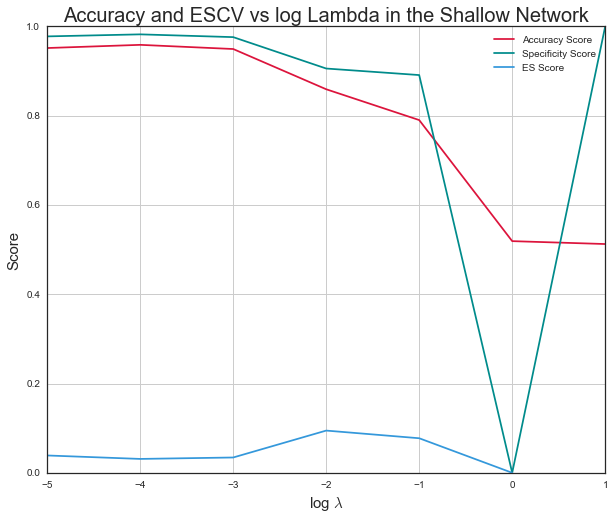

In [95]:
plt.style.use('seaborn-white')
plt.figure(figsize=(10,8))
plt.title('Accuracy and ESCV vs log Lambda in the Shallow Network', fontsize=20)
plt.plot(x , acc_shallow, color = 'crimson', label='Accuracy Score')
plt.plot(x , spe_shallow, color = 'darkcyan', label='Specificity Score')
plt.plot(x , ES_shallow, color = '#3498db', label='ES Score')
plt.xlabel('log $\lambda$', fontsize=15)
plt.ylabel('Score', fontsize=15)
plt.legend()
plt.grid(True)

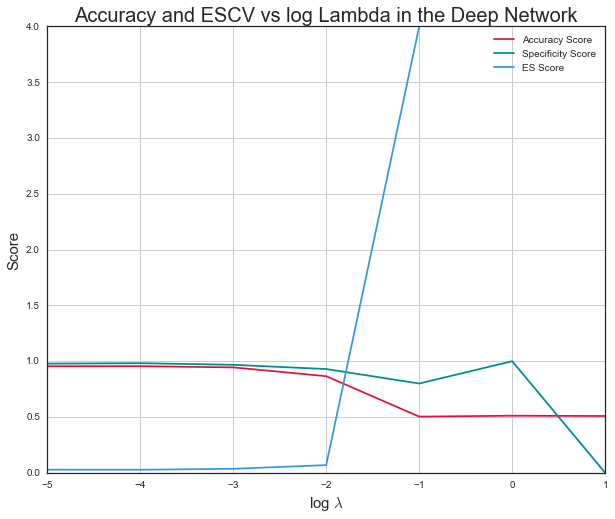

In [93]:
plt.style.use('seaborn-white')
plt.figure(figsize=(10,8))
plt.title('Accuracy and ESCV vs log Lambda in the Deep Network', fontsize=20)
plt.plot(x , acc_deep, color = 'crimson', label='Accuracy Score')
plt.plot(x , spe_deep, color = 'darkcyan', label='Specificity Score')
plt.plot(x , ES_deep, color = '#3498db', label='ES Score')
plt.xlabel('log $\lambda$', fontsize=15)
plt.ylabel('Score', fontsize=15)
plt.legend()
plt.grid(True)

## Testing

In [312]:
print 'data ',len(data)
print 'training ',len(balanced_X)
print 'validation ',len(X_valid)
print 'testing should be ',int(len(data)*.2)

data  14211
training  2004
validation  2764
testing should be  2842


In [313]:
#making the seen datafram
seen = np.concatenate([balanced_X, X_valid])

In [318]:
#converting pandas to numpy
data = np.array(data)

In [323]:
#drawing thresholds
data = data[(data[:,-1]>.7)|(data[:,-1]<0.3)]

In [328]:
#making labels
data[:,-1] = map(lambda x: int(x>0.7),data[:,-1])

In [343]:
#drawing randomly from the big dataframe
testing_indices = np.random.choice(range(len(data)),size=len(seen),replace=False)

In [344]:
testding_df = data[testing_indices]

In [347]:
#getting the first 2842 samples that are not in the seen
unique_testing_indices = np.where((np.sum(testding_df[:,:-1]==seen, axis=1))!=299)[:2842]

In [348]:
#getting the unique datas for testing
testing_data = testding_df[unique_testing_indices]

In [351]:
X_test = testing_data[:,:-1]
y_test = testing_data[:,-1]

In [356]:
with open('X_test','w') as f:
    pickle.dump(X_test, f)
with open('y_test','w') as f:
    pickle.dump(y_test, f)

In [352]:
#Accuracy of Random forest
accuracy_score(y_test, rf.predict(X_test))

0.87077826725403817

In [353]:
model_all_layers = model_from_json(open('model_all_layers.json').read())
model_all_layers.load_weights('model_all_layers_weights.h5')

model_MLP = model_from_json(open('model_MLP.json').read())
model_MLP.load_weights('model_MLP_weights.h5')

In [355]:
print accuracy_score(y_test, model_all_layers.predict_classes(X_test, verbose = 0))
print accuracy_score(y_test, model_MLP.predict_classes(X_test, verbose = 0))

0.807635829662
0.826515628278


In [357]:
print accuracy_score(y_valid_labels, rf.predict(X_valid))
print accuracy_score(y_valid_labels, model_all_layers.predict_classes(X_valid, verbose = 0))
print accuracy_score(y_valid_labels, model_MLP.predict_classes(X_valid, verbose = 0))

0.843704775687
0.781837916064
0.804269175109


## Decision Surfaces

In [15]:
# probs_rf,preds_all_validation, preds_mlp_validation
pca = PCA(5)

In [166]:
probs_rf = rf.predict_proba(X_valid)
preds_all_validation = model_all_layers.predict(X_valid)
preds_mlp_validation = model_MLP.predict(X_valid)

In [142]:
X_valid_pc = pca.fit_transform(X_valid)

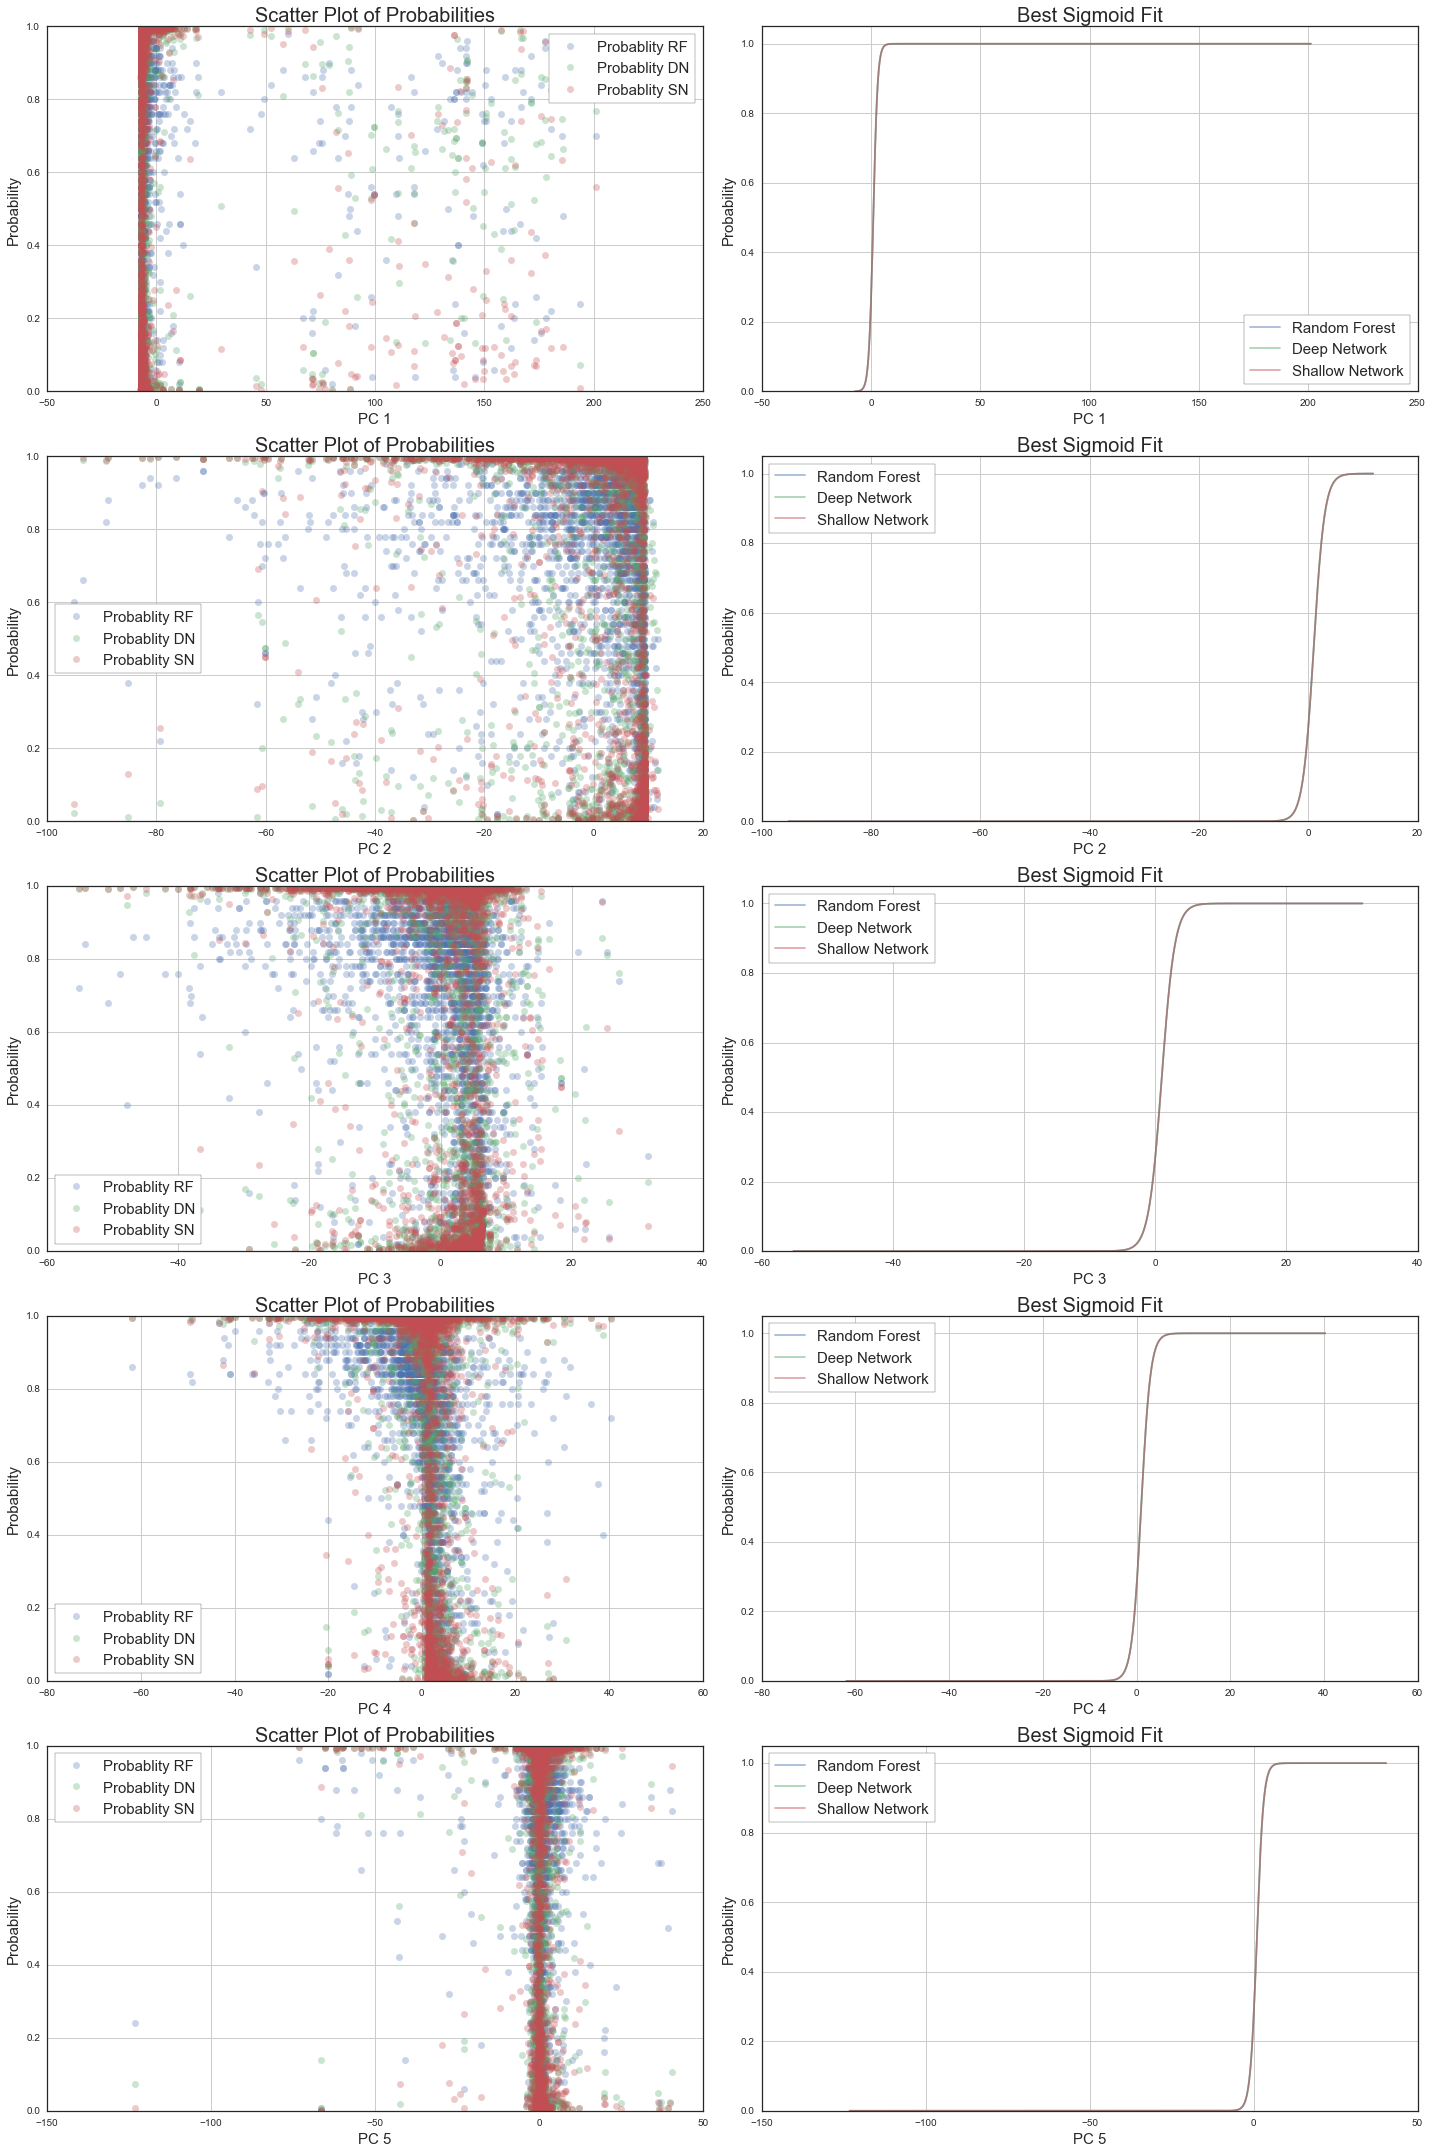

In [167]:
def sigmoid(x, x0, k):
    y = 1 / (1 + np.exp(-k*(x-x0)))
    return y

plt.style.use('seaborn-notebook')
plt.figure(figsize=(20,30))
pc = 5
for i in range(pc):
    popt_rf, pcov_rf = curve_fit(sigmoid, X_valid_pc[:,i], probs_rf[:,1])
    popt_dn, pcov_dn = curve_fit(sigmoid, X_valid_pc[:,i], preds_all_validation[:,1])
    popt_sn, pcov_sn = curve_fit(sigmoid, X_valid_pc[:,i], preds_mlp_validation[:,1])

    x = np.linspace(min(X_valid_pc[:,i]), max(X_valid_pc[:,i]), 1000)
    y_rf = sigmoid(x, *popt_rf)
    y_dn = sigmoid(x, *popt_dn)
    y_sn = sigmoid(x, *popt_sn)
    
    plt.subplot(pc,2,2*i+1)
    plt.plot(X_valid_pc[:,i], probs_rf[:,1], 'o', label='Probablity RF', alpha=.3)
    plt.plot(X_valid_pc[:,i], preds_all_validation[:,1], 'o', label='Probablity DN', alpha=.3)
    plt.plot(X_valid_pc[:,i], preds_mlp_validation[:,1], 'o', label='Probablity SN', alpha=.3)
    plt.legend(loc='best',fontsize=15, frameon=1)
    plt.title("Scatter Plot of Probabilities", fontsize=20)
    plt.xlabel("PC %d"%(i+1), fontsize=15)
    plt.ylabel("Probability", fontsize=15)
    plt.grid()
    
    plt.subplot(pc,2,2*i+2)
    plt.plot(x,y_rf, label='Random Forest', alpha=.5)
    plt.plot(x,y_dn, label='Deep Network', alpha=.5)
    plt.plot(x,y_sn, label='Shallow Network', alpha=.5)
    plt.ylim(0, 1.05)
    plt.legend(loc='best',fontsize=15, frameon=1)
    plt.title("Best Sigmoid Fit",fontsize=20)
    plt.xlabel("PC %d"%(i+1), fontsize=15)
    plt.ylabel("Probability", fontsize=15)
    plt.grid()
 
plt.tight_layout()

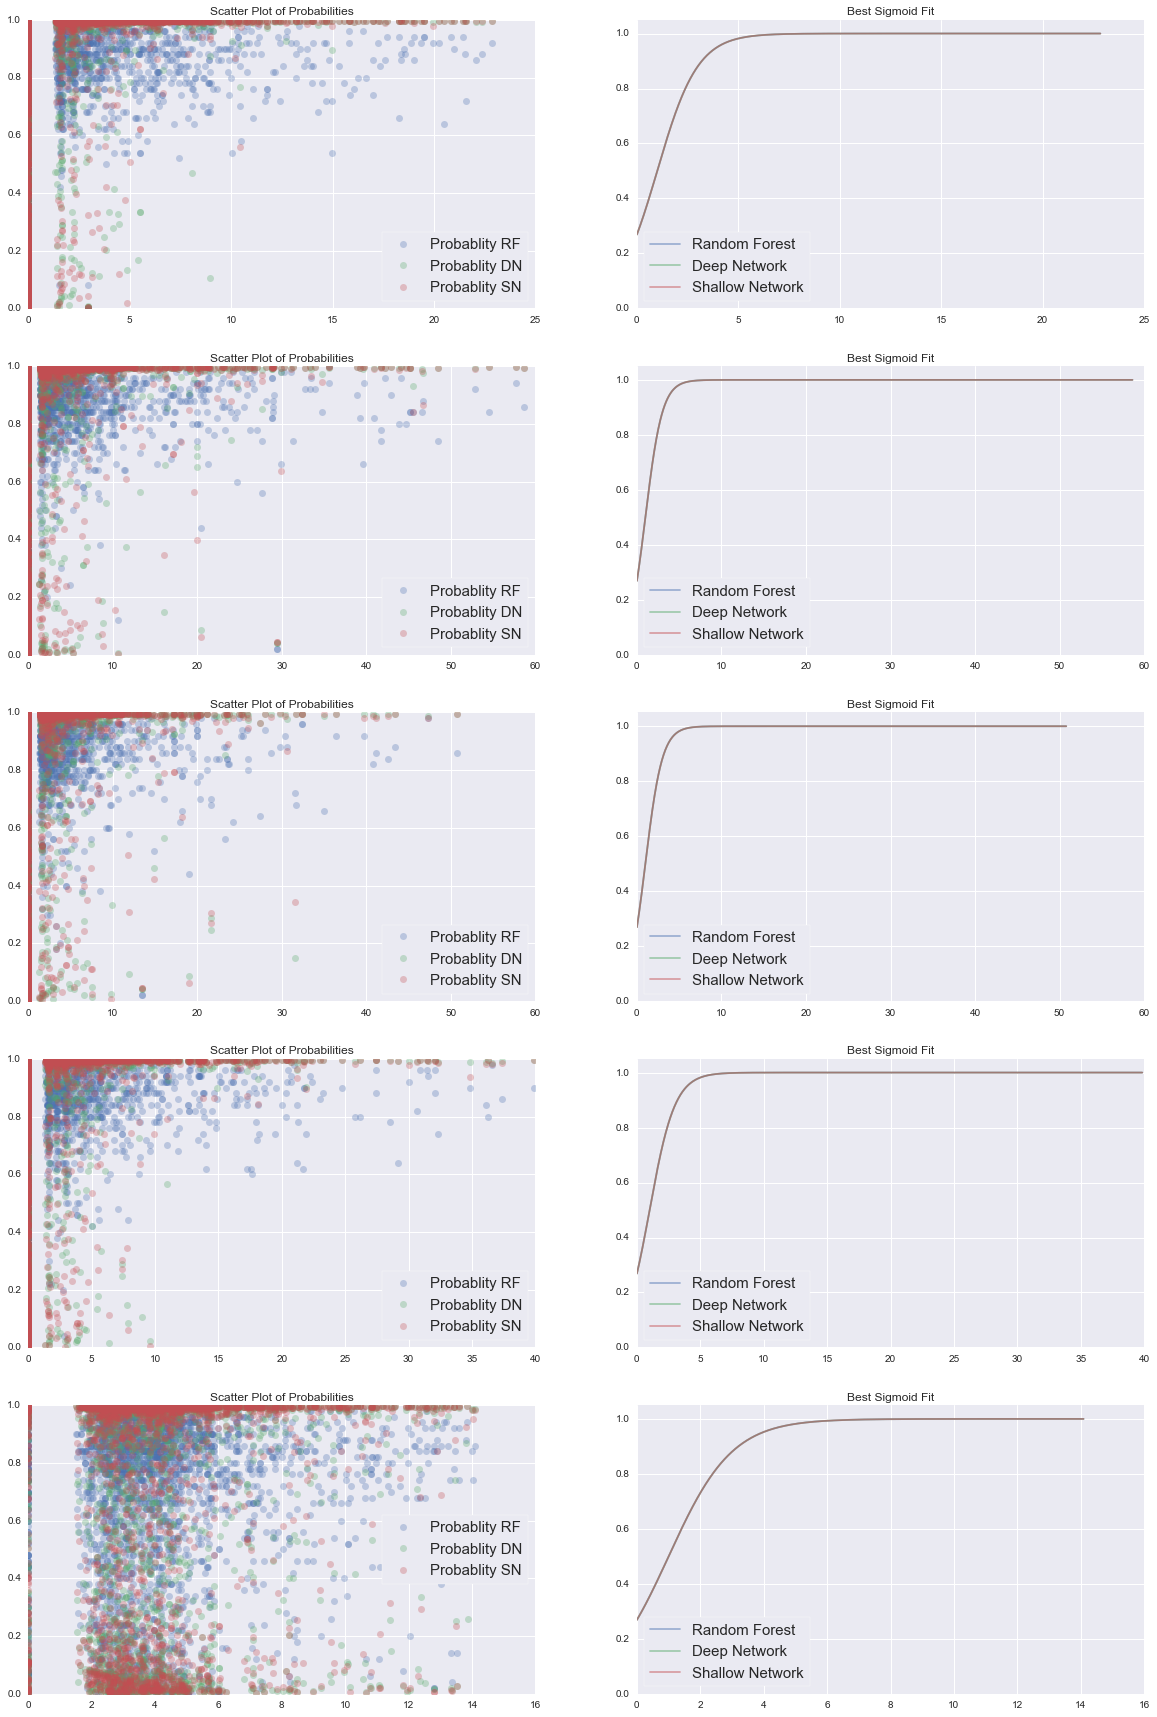

In [144]:
importants = [277, 292, 295, 296, 249]
plt.figure(figsize=(20,30))
for i,feature in enumerate(importants):
    popt_rf, pcov = curve_fit(sigmoid, X_valid[:,feature], probs_rf[:,1])
    popt_dn, pcov = curve_fit(sigmoid, X_valid[:,feature], preds_all_validation[:,1])
    popt_sn, pcov = curve_fit(sigmoid, X_valid[:,feature], preds_mlp_validation[:,1])

    x = np.linspace(min(X_valid[:,feature]), max(X_valid[:,feature]), 1000)
    y_rf = sigmoid(x, *popt_rf)
    y_dn = sigmoid(x, *popt_dn)
    y_sn = sigmoid(x, *popt_sn)
    
    plt.subplot(pc,2,2*i+1)
    plt.plot(X_valid[:,feature], probs_rf[:,1], 'o', label='Probablity RF', alpha=.3)
    plt.plot(X_valid[:,feature], preds_all_validation[:,1], 'o', label='Probablity DN', alpha=.3)
    plt.plot(X_valid[:,feature], preds_mlp_validation[:,1], 'o', label='Probablity SN', alpha=.3)
    plt.legend(loc='best',fontsize=15, frameon=1)
    plt.title("Scatter Plot of Probabilities")
    
    plt.subplot(pc,2,2*i+2)
    plt.plot(x,y_rf, label='Random Forest', alpha=.5)
    plt.plot(x,y_dn, label='Deep Network', alpha=.5)
    plt.plot(x,y_sn, label='Shallow Network', alpha=.5)
    plt.ylim(0, 1.05)
    plt.legend(loc='best',fontsize=15, frameon=1)
    plt.title("Best Sigmoid Fit")

In [168]:
probs_rf = rf.predict(X_valid)
preds_all_validation = model_all_layers.predict_classes(X_valid)
preds_mlp_validation = model_MLP.predict_classes(X_valid)

2764/2764 [==============================] - 0s     


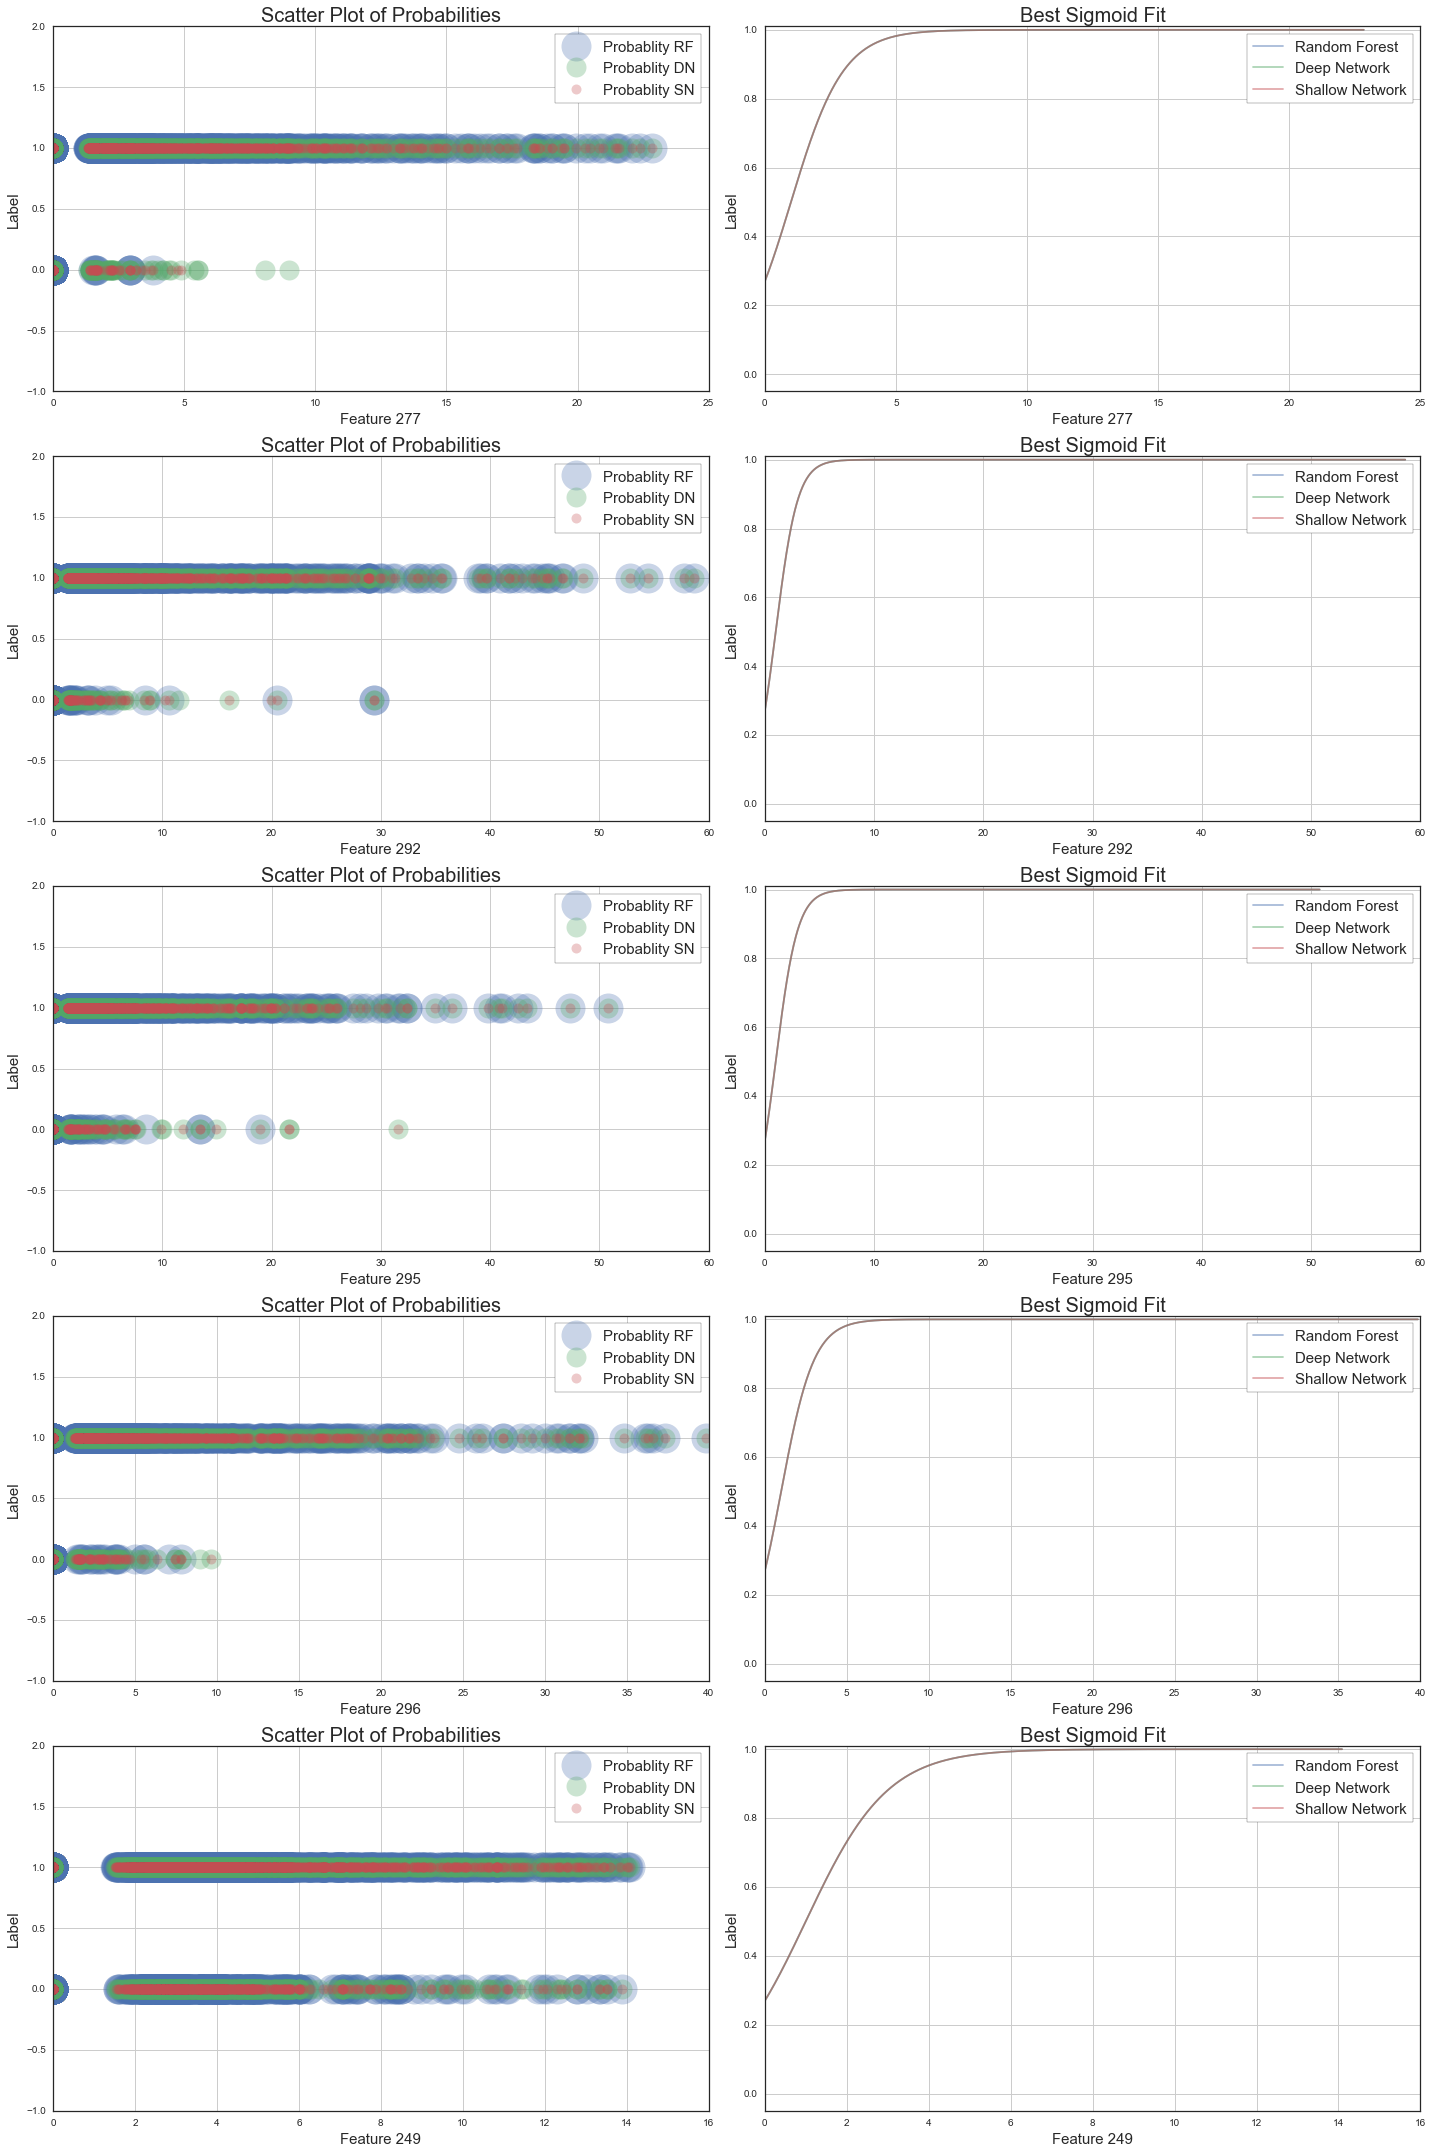

In [177]:
#The sigmoid function whose parameters scipy will estimate, x0 and k will be estimated
def sigmoid(x, x0, k):
    y = 1 / (1 + np.exp(-k*(x-x0)))
    return y

#Choosing the style for our plots
plt.style.use('seaborn-notebook')
#Setting the overall size of the canvas
plt.figure(figsize=(20,30))
#Number of principle components
pc = 5
#The column number of important features
importants = [277, 292, 295, 296, 249]

for i,feature in enumerate(importants):
    #Fitting random forest, deep network and shallow network sigmoids using a feature and 
    #its predicted probability
    popt_rf, pcov_rf = curve_fit(sigmoid, X_valid[:,feature], probs_rf)
    popt_dn, pcov_dn = curve_fit(sigmoid, X_valid[:,feature], preds_all_validation)
    popt_sn, pcov_sn = curve_fit(sigmoid, X_valid[:,feature], preds_mlp_validation)
    
    #Creating a range of numbers, feeding them to the fitted sigmoid
    x = np.linspace(min(X_valid[:,feature]), max(X_valid[:,feature]), 1000)
    y_rf = sigmoid(x, *popt_rf)
    y_dn = sigmoid(x, *popt_dn)
    y_sn = sigmoid(x, *popt_sn)
    
    #Choosing the number of plot in (number of plot, grid row, grid column)
    plt.subplot(pc,2,2*i+1)
    #Scattering the values of random forest and the networks with different sizes
    plt.plot(X_valid[:,feature], probs_rf, 'o', label='Probablity RF', alpha=.3, markersize=30)
    plt.plot(X_valid[:,feature], preds_all_validation, 'o', label='Probablity DN', alpha=.3, markersize=20)
    plt.plot(X_valid[:,feature], preds_mlp_validation, 'o', label='Probablity SN', alpha=.3, markersize=10)
    plt.legend(loc='best',fontsize=15, frameon=1)
    plt.title("Scatter Plot of Probabilities", fontsize=20)
    plt.xlabel("Feature %d"%(feature), fontsize=15)
    plt.ylabel("Label", fontsize=15)
    plt.ylim(-1,2)
    plt.grid()
    
    plt.subplot(pc,2,2*i+2)
    #Plotting the sigmoid for the classifiers
    plt.plot(x,y_rf, label='Random Forest', alpha=.5)
    plt.plot(x,y_dn, label='Deep Network', alpha=.5)
    plt.plot(x,y_sn, label='Shallow Network', alpha=.5)
    plt.legend(loc='best',fontsize=15, frameon=1)
    plt.title("Best Sigmoid Fit",fontsize=20)
    plt.xlabel("Feature %d"%(feature), fontsize=15)
    plt.ylabel("Label", fontsize=15)
    plt.grid()
    plt.ylim(-.05,1.01)
 
 #This line will make the plots appear better where there is less space
plt.tight_layout()


In [2]:
with open('X_test','r') as f:
    X_test = pickle.load(f)

In [3]:
len(X_test)

4767